### The following is my main workbook which goes through EDA, modelling and running a trading strategy using clustering.

In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#### Importing libraries 

In [160]:
#If in colab
#!pip install telethon

import pandas as pd
import re
import requests
from datetime import datetime, timedelta, date
import numpy as np
import pytz
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import statistics

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, Ridge
from sklearn.pipeline import Pipeline
import matplotlib.dates as mdates

from sklearn.svm import SVR

from sklearn.decomposition import PCA

import ccxt


#### Importing coin list

In [3]:
import requests
import csv

def fetch_cryptocurrencies(per_page=250):
    url = "https://api.coingecko.com/api/v3/coins/markets"
    page = 1
    all_cryptos = []

    while True:
        params = {
            'vs_currency': 'usd',
            'order': 'market_cap_desc',
            'per_page': per_page,
            'page': page
        }
        response = requests.get(url, params=params)
        if response.status_code != 200:
            break
        data = response.json()
        if not data:
            break
        all_cryptos.extend(data)
        page += 1

    return all_cryptos

def save_to_csv_using_dataframe(cryptos, filename):
    df = pd.DataFrame(cryptos)

    df = df[['id', 'name', 'symbol', 'market_cap', 'total_volume']]
    df.columns = ['ID', 'Name', 'Ticker', 'Market Cap', '24h Volume']

    df.to_csv(filename, index=False)



#### Cleaning - Keeping those with daily volume >$500k

In [4]:
#Keeping those with >$500k ADV

try:
    cryptocurrencies_list = 'complete_coins_list.csv'
except:
    data = fetch_cryptocurrencies()
    if data:
        save_to_csv_using_dataframe(data, 'complete_coins_list.csv')
    
cryptocurrencies_list = 'complete_coins_list.csv'
coins_list = pd.read_csv(cryptocurrencies_list)
coins_list = coins_list[coins_list['24h Volume'] > 500000]
crypto_symbols_set = set(coins_list['Ticker'].str.upper()) # faster lookup

In [5]:
coins_list.head()

,ID,Name,Ticker,Market Cap,24h Volume
0,bitcoin,Bitcoin,btc,841735458687,1.294936e+10
1,ethereum,Ethereum,eth,279894788156,7.583339e+09
2,tether,Tether,usdt,96147605353,2.583855e+10
3,binancecoin,BNB,bnb,46679514342,5.201413e+08
4,solana,Solana,sol,41408261036,1.640421e+09


#### Below I am setting up functions to pull prices from both coingecko (which has more coins but is less reliable) and also cctx which is more reliable and can take a higher usage, but has less coins and less history

In [6]:
def pull_prices_cg(days, coin):
    
    coin = coin.lower()

    filtered_series = coins_list[coins_list['Ticker'] == coin]['ID']

    # To get the index of the coin in the filtered series, wihc will be used in a loc lookuip
    indices = filtered_series.index

    if not indices.empty:
        first_index = indices[0]  # Gets the first index of the filtered series
        coin_id = coins_list.loc[first_index, 'ID']
    
    url = f"https://api.coingecko.com/api/v3/coins/{coin_id}/market_chart"
    parameters = {
        'vs_currency': 'usd',
        'days': days,
    }
    response = requests.get(url, params=parameters)
    data = response.json()

    df_prices = pd.DataFrame(data['prices'], columns=['time', 'price'])
    df_volumes = pd.DataFrame(data['total_volumes'], columns=['time', '24h_volume'])
    
    
    df_prices['Date'] = pd.to_datetime(df_prices['time'], unit='ms').dt.date  # Converts timestamp to date
    sorted_prices = df_prices.sort_values(by='time')
    daily_closing_prices = sorted_prices.drop_duplicates('Date', keep='last')[['Date', 'price']]
    daily_closing_prices.reset_index(inplace=True, drop=True)
    daily_closing_prices['Date'] = pd.to_datetime(daily_closing_prices['Date'])

    df_volumes['Date'] = pd.to_datetime(df_volumes['time'], unit='ms').dt.date  # Converts timestamp to date
    sorted_volumes = df_volumes.sort_values(by='time')
    daily_closing_volumes = sorted_volumes.drop_duplicates('Date', keep='last')[['Date', '24h_volume']]
    daily_closing_volumes.reset_index(inplace=True, drop=True)
    daily_closing_volumes['Date'] = pd.to_datetime(daily_closing_volumes['Date'])
    
    df_price = pd.merge(daily_closing_prices, daily_closing_volumes, on='Date')
    
    
    return df_price
    
    

        


In [7]:
pull_prices_cg(7, 'BONK')


,Date,price,24h_volume
0,2024-03-05,0.000031,1.342659e+09
1,2024-03-06,0.000030,6.479008e+08
2,2024-03-07,0.000027,5.020514e+08
3,2024-03-08,0.000033,9.091342e+08
4,2024-03-09,0.000034,4.802585e+08
5,2024-03-10,0.000031,3.852332e+08
6,2024-03-11,0.000030,3.514270e+08
7,2024-03-12,0.000029,3.069504e+08


In [8]:
def pull_prices(days, coin):
    exchange_id = 'binance'
    exchange_class = getattr(ccxt, exchange_id)
    exchange = exchange_class({
        'timeout': 30000,
        'enableRateLimit': True,
    })

    symbol = coin
    symbol = f'{coin}/USDT'
    timeframe = '1d'

    seven_days_ago = datetime.utcnow() - timedelta(days=days)
    since = int(seven_days_ago.timestamp() * 1000)  # Convert to milliseconds

    all_ohlcv = []
    limit = 500  # Adjust based on exchange limits

    # Fetch OHLCV data starting from x days ago, handling pagination if necessary
    while True:
        ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since, limit)
        if len(ohlcv) == 0:
            break  # No more data to fetch
        all_ohlcv += ohlcv
        since = ohlcv[-1][0] + 1  # Update 'since' to get the next batch of data

    df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df_prices = df[['timestamp', 'close', 'volume']]
    df_prices = df_prices.rename(columns={'timestamp': 'Date', 'close': 'price', 'volume':'24h_volume'})

    return df_prices




def merge_coin_prices(df, master, coin):
    new_df = pd.concat([df, master], axis = 0)# sort=True)
    new_df = new_df.drop_duplicates(subset=['Date'])
    new_df['Date'] = pd.to_datetime(new_df['Date'])
    new_df = new_df.sort_values(by='Date')
    master = new_df
    master.to_csv(f'coin_prices/{coin}.csv')

    return new_df

In [9]:
pull_prices(5, 'BTC')

,Date,price,24h_volume
0,2024-03-08,68124.19,74261.932842
1,2024-03-09,68313.27,19872.897430
2,2024-03-10,68955.88,38404.668350
3,2024-03-11,72078.10,75292.825726
4,2024-03-12,72110.21,32202.095571


#### As for the telegram scrape, this is being imported from colab, since the Hugging Face library needs to be run on a GPU

In [177]:
#Importing this from colab - this is a full history of comments with sentiment scores, filtered for those comments that have an identified coin

df = pd.read_csv('Master_sentiment_new.csv')

In [178]:
df.shape

(29359, 20)

### Initial EDA on the comments dataset

#### Let's look at the accuracy of the sentiment scores for the last 20 comments to see if the sentiment scoring is broadly accurate. I have no better way to do this than a manual check as I have no well categorized training set.


In [13]:
df

,Unnamed: 0.6,Unnamed: 0.1,Unnamed: 0,message.sender_id,message.text,message.date,message.id,message.reply_to_msg_id,message.post_author,message.views,message.peer_id.channel_id,group,Date,extracted_coins,coin_mentions,sentiment_score,Unnamed: 0.5,Unnamed: 0.4,Unnamed: 0.3,Unnamed: 0.2
0,0,15.0,15,-1.001423e+12,FYI: This is a look at the FTX estate Solana O...,2024-03-07 16:32:47+00:00,4802,NaN,NaN,423.0,1423153458,investingbeanstock,2024-03-07 16:32:47+00:00,['SOL'],['SOL'],2.528390,NaN,NaN,NaN,NaN
1,1,16.0,16,-1.001423e+12,The great $SOL repricing 🫡\n\nhttps://x.com/bl...,2024-03-07 16:28:15+00:00,4801,NaN,NaN,418.0,1423153458,investingbeanstock,2024-03-07 16:28:15+00:00,['SOL'],['SOL'],6.053952,NaN,NaN,NaN,NaN
2,2,20.0,20,-1.002018e+12,**New video from** [Coin Bureau](https://www.y...,2024-03-07 16:06:31+00:00,1794,NaN,NaN,15.0,2017689163,TPLXPodcastInsights,2024-03-07 16:06:31+00:00,"['FIL', 'FIL', 'FIL', 'FIL', 'FIL', 'FIL']",['FIL'],2.069995,NaN,NaN,NaN,NaN
3,3,22.0,22,8.278026e+08,"Gm guys, just dropped a thread about chainflip...",2024-03-07 16:03:00+00:00,17694,NaN,NaN,NaN,1611549397,OuroborosNarratives,2024-03-07 16:03:00+00:00,"['BTC', 'ETH']","['BTC', 'ETH']",8.365355,NaN,NaN,NaN,NaN
4,4,36.0,36,-1.001267e+12,And people faded $JTO 😂,2024-03-07 14:59:01+00:00,33272,NaN,NaN,1490.0,1267247632,joescrypt,2024-03-07 14:59:01+00:00,['JTO'],['JTO'],-0.673844,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29354,13969,133092.0,133092,2.169006e+08,Yea I think that’s it,2022-01-19 12:44:30+00:00,316718,316717.0,NaN,NaN,1242127973,lobsters_chat,2022-01-19 12:44:30+00:00,['BSV'],['BSV'],2.103874,13887.0,13726.0,13638.0,13518.0
29355,13970,133093.0,133093,3.680080e+08,Actually reading (attempting to understand the...,2022-01-19 12:42:36+00:00,316717,NaN,NaN,NaN,1242127973,lobsters_chat,2022-01-19 12:42:36+00:00,['BSV'],['BSV'],-0.889671,13888.0,13727.0,13639.0,13519.0
29356,13971,133100.0,133100,1.225668e+09,"But ser, there are only vampire attacks on Fan...",2022-01-19 11:49:16+00:00,316708,316684.0,NaN,NaN,1242127973,lobsters_chat,2022-01-19 11:49:16+00:00,['NFT'],['NFT'],-2.021410,13889.0,13728.0,13640.0,13520.0
29357,13972,133111.0,133111,2.169006e+08,They are doing a CVX model?,2022-01-19 11:37:48+00:00,316685,316679.0,NaN,NaN,1242127973,lobsters_chat,2022-01-19 11:37:48+00:00,['CVX'],['CVX'],0.087488,13890.0,13729.0,13641.0,13521.0


In [16]:
for i in range(23949,23958):
    print(df.loc[i,'message.text'], df.loc[i,'sentiment_score'], df.loc[i,'coin_mentions'])

What is happening with FRAX? Can’t get a reply from anyone there and you can’t bridge money of Moonbeam eventho they are on it..???? 
EDIT: Barely got one response from a mod thats about it and it wasnt helpfull -9.1140656452626 ['FRAX']
Tldr on frxeth, please? Is it just wrapper of steth or something more? 0.1128886267542839 ['FRAX']
At least FRAX offers us some bear market sweetener -1.4828917384147644 ['FRAX']
Do you know any good bridges for solana? 0.7443760894238949 ['SOL']
Just look at their balance sheet. There's $863 million of locked SOL that's going to be liquidated in the bankruptcy process -4.569673519581556 ['SOL']
Which bridge did you use? Any good bridge to bridge USDC (sol)? 0.7837572880089283 ['USDC']
[​​​​​​​​​​​[](https://chaindebrief.com/wp-content/uploads/2022/11/STRAITX-1024x576.png)Off-Ramp Your Crypto Directly To Your DBS/UOB Account With StraitsX](https://chaindebrief.com/off-ramp-your-crypto-directly-to-your-dbs-uob-account-with-straitsx/) 

With all the FUD 

#### There's a lot of noise and also eg NFT is identified as a project (this is because NFT is a ticker but is also a standard in crypto ie non-fungible tokens).

#### Lets limit the analysis to comments better or worse than 5 or -5.

In [17]:
df_5 = df[(df['sentiment_score'] > 5) | (df['sentiment_score'] < -5)]
df_5.reset_index(inplace=True)
df_5[['message.text', 'sentiment_score', 'coin_mentions']][-20:]

,message.text,sentiment_score,coin_mentions
7995,idk who's still writing SC without tests & try...,-7.937501,['SC']
7996,i did some pet projects and worked with one st...,7.075808,['SC']
7997,a DAO forming to farm an airdrop doesn't feel ...,-8.935671,['DAO']
7998,@ivangbi’s USDC bags are pumping!,5.045242,['USDC']
7999,Hi! Appreciate 🦞 Let’s keep the discussion in ...,9.494906,['DAO']
8000,Hi Lobsters \nCheck out the Proposal to work a...,5.434239,['DAO']
8001,I used Rubic Multichain-bridge to bridge ETH t...,8.486716,"['USDC', 'ETH', 'FTM']"
8002,yea they have one it wont do anything for liqu...,-7.046021,['FTM']
8003,"People aped in ftm so hard, drainned the liqui...",-6.008890,['FTM']
8004,Almost no liquidity either. Like Mog said it's...,-7.749503,['FTM']


In [20]:
for i in range(8005,8015):
    print(df_5.loc[i,'message.text'], df_5.loc[i,'sentiment_score'], df_5.loc[i,'coin_mentions'])

ugh i ignore personal comments. you can question or point out any incorrect facts or statements i make. -7.294687032699585 ['NFT']
yes this is fine really and when dust is settled grapes will work with everyone who want to collaborate

did not mean to be harsh but perhaps complaint of mine is more to be grouped together with such farm-to-get-NFT protocols when we really are give-NFT-so-you-can-farm protocol 5.307960417121649 ['NFT']
The problem is with approvals. If you have a wETH approval for the vulnerable contract and you get wETH from any source you're at risk. That includes wrapping ETH but not unwrapping. -6.895768875256181 ['ETH']
You got exploited. Looks like the wETH went to a wallet that's exploiting the Multichain exploit: https://etherscan.io/tx/0xc57d154089623364c1935389efeaac8c31d6ce489bff739b8b202bcc8d021836 -8.172837905585766 ['ETH']
Anyone who wants to know the answer to the fractionalization problem, this is something you could pretty easily accomplished with Revest.

#### I would say this is mixed, with a lot of noise given many of the comments are replies to earlier comments around a specific coin and so can become only spuriously relevant, but anyway, the approach at least is directionally right in most cases.

#### Let's continue with our analysis. We are now trying to see mentions of a specific coin on a specific date, so that we can compare this to price and see sentiment and comment volume vs price over time and build coin specific dataframes.

In [21]:
# First, convert ' message.date' to datetime and extract the date
df['date'] = pd.to_datetime(df[' message.date']).dt.date

In [22]:
def group_data(df):
    #This creates a df with each comment having its own line, with mentions and avg sentiment
    #explode - each coin mention get own line
    exploded_telegram_comments_df = df.explode('coin_mentions')
    #df['coin_mentions'] = df['coin_mentions'].apply(eval)

    #groupby date and then coin mentions and add num_mentions as count of message.text and 
    #avg_sentiment as mean sentiment score. Then reset index
    grouped_telegram_comments_data = exploded_telegram_comments_df.groupby(['date', 'coin_mentions']).agg(
        num_mentions=pd.NamedAgg(column="message.text", aggfunc="count"),
        avg_sentiment_score=pd.NamedAgg(column="sentiment_score", aggfunc="mean")
    ).reset_index()


    # Filter out rows with no coin mentions
    grouped_telegram_comments_data = grouped_telegram_comments_data[grouped_telegram_comments_data['coin_mentions'].notna()]

    grouped_telegram_comments_data['date'] = pd.to_datetime(grouped_telegram_comments_data['date'])
    
    return grouped_telegram_comments_data

In [24]:
#New function to explode coins mentioned
def group_data_new(df):
    
    # Convert 'coin_mentions' from string representation of list to actual list
    df['coin_mentions'] = df['coin_mentions'].apply(eval)
    
    #This creates a df with each comment having its own line, with mentions and avg sentiment
    #explode - each coin mention get own line
    
    exploded_telegram_comments_df = df.explode('coin_mentions')

    #groupby date and then coin mentions and add num_mentions as count of message.text and 
    #avg_sentiment as mean sentiment score. Then reset index
    grouped_telegram_comments_data = exploded_telegram_comments_df.groupby(['date', 'coin_mentions']).agg(
        num_mentions=pd.NamedAgg(column="message.text", aggfunc="count"),
        avg_sentiment_score=pd.NamedAgg(column="sentiment_score", aggfunc="mean")
    ).reset_index()


    # Filter out rows with no coin mentions
    grouped_telegram_comments_data = grouped_telegram_comments_data[grouped_telegram_comments_data['coin_mentions'].notna()]

    grouped_telegram_comments_data['date'] = pd.to_datetime(grouped_telegram_comments_data['date'])
    
    return grouped_telegram_comments_data




In [25]:
grouped_telegram_comments_data = group_data(df)
grouped_telegram_comments_data

,date,coin_mentions,num_mentions,avg_sentiment_score
0,2022-01-19,['BSV'],9,0.757956
1,2022-01-19,['BTC'],1,7.058899
2,2022-01-19,['CVX'],1,0.087488
3,2022-01-19,['ETH'],2,0.616151
4,2022-01-19,['NFT'],6,-0.199044
...,...,...,...,...
8545,2024-03-07,['JTO'],2,0.300536
8546,2024-03-07,['JUP'],1,-4.482664
8547,2024-03-07,['NEON'],1,1.132033
8548,2024-03-07,['NEXT'],14,-1.255435


In [26]:
#Occasionally, coin_mentions is a column of lists and so def group_data_new(df) is used to 
#convert lists into strings

grouped_telegram_comments_data_new = group_data_new(df)

In [27]:
grouped_telegram_comments_data_new.tail(10)

,date,coin_mentions,num_mentions,avg_sentiment_score
8860,2024-03-07,ETH,4,4.911966
8861,2024-03-07,FIL,1,2.069995
8862,2024-03-07,GTC,2,3.674178
8863,2024-03-07,INSP,2,-0.379774
8864,2024-03-07,JTO,2,0.300536
8865,2024-03-07,JUP,1,-4.482664
8866,2024-03-07,NEON,1,1.132033
8867,2024-03-07,NEXT,14,-1.255435
8868,2024-03-07,SOL,11,3.548537
8869,2024-03-07,SUI,2,6.797073


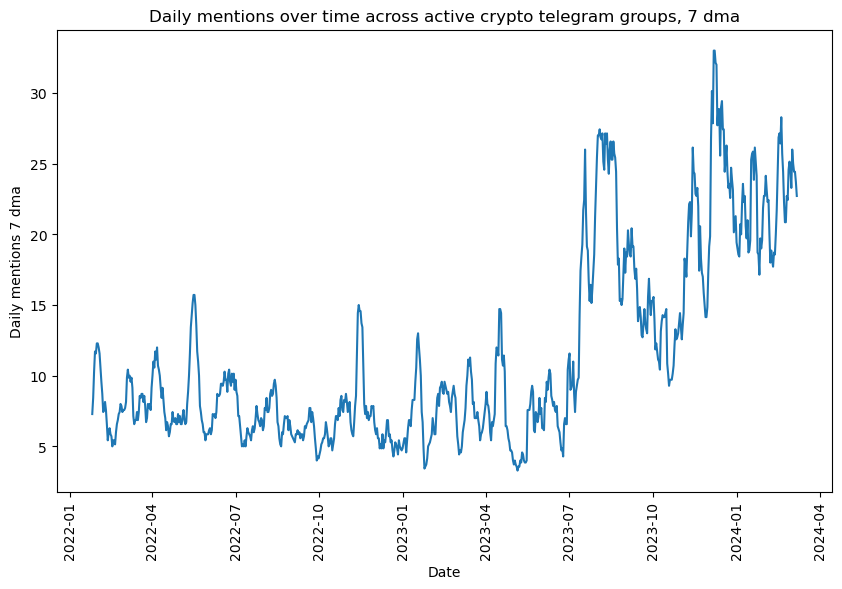

In [32]:
group_mentions = grouped_telegram_comments_data_new.groupby('date')['num_mentions'].count()

group_mentions_7dma = group_mentions.rolling(window=7).mean()

plt.figure(figsize=(10,6))
plt.plot(group_mentions_7dma.index, group_mentions_7dma.values)
plt.xlabel('Date')
plt.ylabel('Daily mentions 7 dma')
plt.title('Daily mentions over time across active crypto telegram groups, 7 dma')
plt.xticks(rotation=90) 
plt.savefig('mentions_over_time.png')
plt.show()

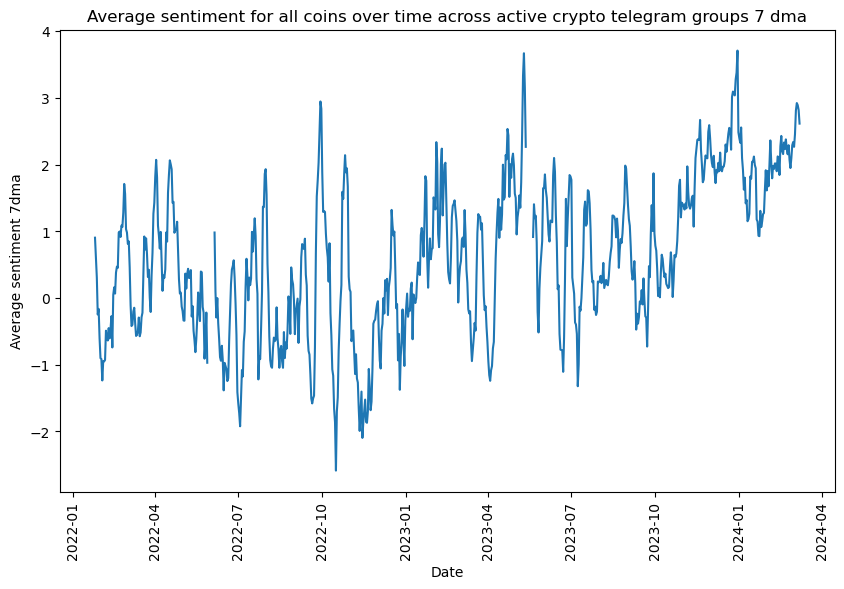

In [34]:
group_sentiment = grouped_telegram_comments_data_new.groupby('date')['avg_sentiment_score'].mean()

group_sentiment_7dma = group_sentiment.rolling(window=7).mean()

plt.figure(figsize=(10,6))
plt.plot(group_sentiment_7dma.index, group_sentiment_7dma.values)
plt.xlabel('Date')
plt.ylabel('Average sentiment 7dma')
plt.title('Average sentiment for all coins over time across active crypto telegram groups 7 dma')
plt.xticks(rotation=90)
plt.savefig('sentiment_over_time.png')
plt.show()

#### As expected, the groups were much more vocal with the improvement in the crypto market in 2H23, but surprisingly, there was a significant pickup in activity around August 2023. 

This might have been due to Solana (the community became much more vocal) and possibly Dogecoin (there was speculation the mascot dog, Kabosu was about to die...), or it could have been due to the launch or development of specific groups within out dataset. 

In terms of sentiment, there was clearly a dramatic improvement in mid Q4, which is not surprising given the improvement in the market.

#### Let's create the initial charts which show us the hottest coins that day and week by 'shill score', which I have defined as number of mentions * average sentiment per day.


           date coin_mentions  num_mentions  avg_sentiment_score  Shill_score
0    2022-01-19           BSV             9             0.757956     6.821602
1    2022-01-19           BTC             1             7.058899     7.058899
2    2022-01-19           CVX             1             0.087488     0.087488
3    2022-01-19           ETH             2             0.616151     1.232303
4    2022-01-19           NFT             6            -0.199044    -1.194262
...         ...           ...           ...                  ...          ...
8865 2024-03-07           JUP             1            -4.482664    -4.482664
8866 2024-03-07          NEON             1             1.132033     1.132033
8867 2024-03-07          NEXT            14            -1.255435   -17.576088
8868 2024-03-07           SOL            11             3.548537    39.033907
8869 2024-03-07           SUI             2             6.797073    13.594145

[8870 rows x 5 columns]


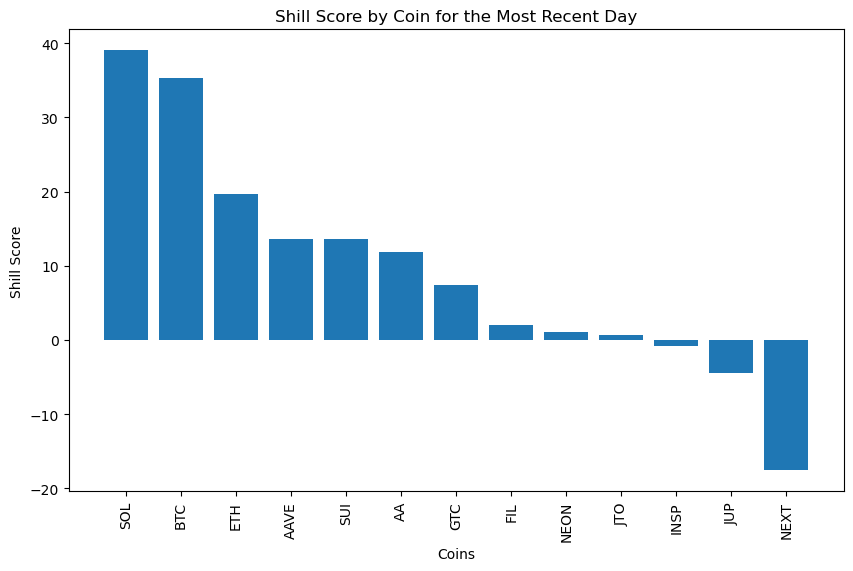

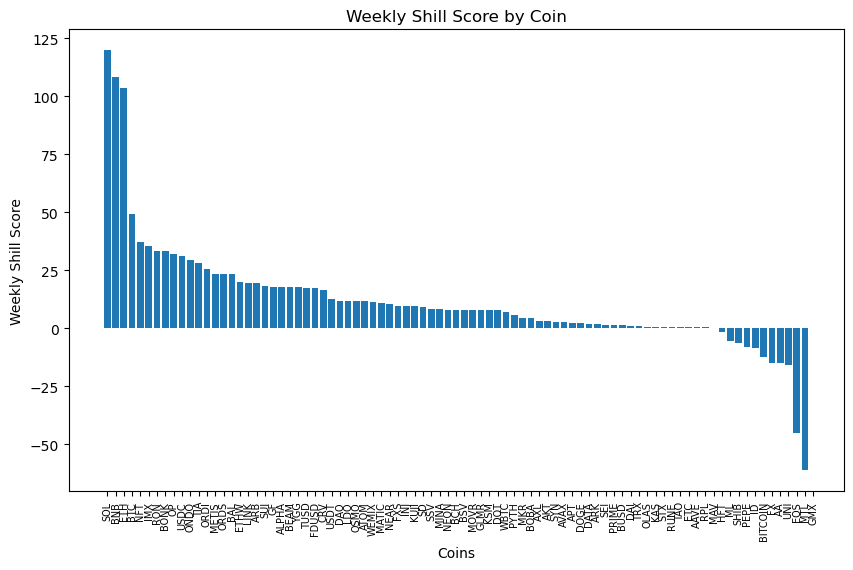

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

def shillometer_charts(df):
    df['coin_mentions'] = df['coin_mentions'].apply(eval) # converts from list to string
    # Explode coin_mentions so each coin mention gets its own line
    exploded_telegram_comments_df = df.explode('coin_mentions')

    # Group by date and then coin mentions and add num_mentions as count of message.text and 
    # avg_sentiment as mean sentiment score. Then reset index
    grouped_telegram_comments_data = exploded_telegram_comments_df.groupby(['date', 'coin_mentions']).agg(
        num_mentions=pd.NamedAgg(column="message.text", aggfunc="count"),
        avg_sentiment_score=pd.NamedAgg(column="sentiment_score", aggfunc="mean")
    ).reset_index()

    # Filter out rows with no coin mentions
    grouped_telegram_comments_data = grouped_telegram_comments_data[grouped_telegram_comments_data['coin_mentions'].notna()]

    grouped_telegram_comments_data['date'] = pd.to_datetime(grouped_telegram_comments_data['date'])

    # Calculate 'Shill score'
    grouped_telegram_comments_data['Shill_score'] = grouped_telegram_comments_data['num_mentions'] * grouped_telegram_comments_data['avg_sentiment_score']

    return grouped_telegram_comments_data

# Load data
df = pd.read_csv('Master_sentiment_new.csv')
df['date'] = pd.to_datetime(df[' message.date']).dt.date

# Apply the grouping function
grouped_df = shillometer_charts(df)

print(grouped_df)

# Get the most recent day's data
most_recent_day = grouped_df['date'].max()
recent_data = grouped_df[grouped_df['date'] == most_recent_day]
recent_data_sorted_desc = recent_data.sort_values(by='Shill_score', ascending=False)

plt.figure(figsize=(10,6))
plt.bar(recent_data_sorted_desc['coin_mentions'], recent_data_sorted_desc['Shill_score'])
plt.xlabel('Coins')
plt.ylabel('Shill Score')
plt.title('Shill Score by Coin for the Most Recent Day')
plt.xticks(rotation=90) 
plt.savefig('daily_shills.png')
plt.show()

# Aggregate data by week
grouped_df['week'] = grouped_df['date'].dt.isocalendar().week
weekly_data = grouped_df.groupby(['week', 'coin_mentions']).agg(
    total_mentions=pd.NamedAgg(column="num_mentions", aggfunc="sum"),
    avg_weekly_sentiment_score=pd.NamedAgg(column="avg_sentiment_score", aggfunc="mean")
).reset_index()

# Calculate 'Weekly Shill score'
weekly_data['Weekly Shill score'] = weekly_data['total_mentions'] * weekly_data['avg_weekly_sentiment_score']

# Get the data for the most recent week
most_recent_week = weekly_data['week'].max()
recent_weekly_data = weekly_data[weekly_data['week'] == most_recent_week]
recent_weekly_data_sorted_desc = recent_weekly_data.sort_values(by='Weekly Shill score', ascending=False)

plt.figure(figsize=(10,6))
plt.bar(recent_weekly_data_sorted_desc['coin_mentions'], recent_weekly_data_sorted_desc['Weekly Shill score'])
plt.xlabel('Coins')
plt.ylabel('Weekly Shill Score')
plt.title('Weekly Shill Score by Coin')
plt.xticks(rotation=90, fontsize=7) 
plt.savefig('weekly_shills.png')
plt.show()



#### Creating the main price and technicals dataframe

Below, I am importing the price and volume history for a specific coin and also creating various technical indicators from that data. We will then use these as features for modelling later on.

In [38]:
def coin_df(days, coin):

    coin_data = grouped_telegram_comments_data[grouped_telegram_comments_data['coin_mentions'].apply(lambda x: coin.upper() in x)]

    #now trying to see rolling dates, with some entries empty so can compare to eg price data
    #build new df with date starting 14 July, ending on last post
    all_dates = pd.DataFrame(pd.date_range(start='2020-07-01', end=coin_data['date'].max()), columns=['date'])

    #merge comments and price data
    merged_coin_data = pd.merge(all_dates, coin_data, how='left', on='date')

    # create shill score
    merged_coin_data['shill_score'] = merged_coin_data['num_mentions'] * merged_coin_data['avg_sentiment_score']

    # fillna
    merged_coin_data['num_mentions'] = merged_coin_data['num_mentions'].fillna(0)
    merged_coin_data['shill_score'] = merged_coin_data['shill_score'].fillna(0)
    merged_coin_data['avg_sentiment_score'] = merged_coin_data['avg_sentiment_score'].fillna(0)
   
    df_price = pull_prices(days, coin)
    
    merged_coin_prices = df_price   
    
    start_date = datetime.strptime('2020-01-01', '%Y-%m-%d')

    # Filter the dataframes
    filtered_coin_data = merged_coin_data[merged_coin_data['date'] >= start_date]
    filtered_price_data = merged_coin_prices[merged_coin_prices['Date'] >= start_date]
    
    #rename date col
    filtered_price_data = filtered_price_data.rename({'Date':'date'}, axis=1)

    #merge
    df = pd.merge(filtered_price_data, filtered_coin_data, how='left', on='date')
    
    # Technicals
    df['20d_ema'] = df['price'].ewm(span=20, adjust=False).mean()
    df['10d_ema'] = df['price'].ewm(span=10, adjust=False).mean()
    df['5d_ema'] = df['price'].ewm(span=5, adjust=False).mean()
    
    df['10_20_ema'] = df['10d_ema'] / df['20d_ema'] 
    df['5_10_ema'] = df['5d_ema'] / df['10d_ema'] 
    
    df['10_20_acc'] = df['10_20_ema'] / df['10_20_ema'].rolling(window=5).mean()
    df['5_10_acc'] = df['5_10_ema'] / df['5_10_ema'].rolling(window=5).mean()

    # 14 day RSI
    delta = df['price'].diff(1)
    gain = (delta.where(delta > 0, 0)).ewm(alpha=1/14, adjust=False).mean()
    loss = (-delta.where(delta < 0, 0)).ewm(alpha=1/14, adjust=False).mean()
    rs = gain / loss
    df['14d_RSI'] = 100 - (100 / (1 + rs))
    
    # 7 day RSI 
    delta = df['price'].diff(1)
    gain = (delta.where(delta > 0, 0)).ewm(alpha=1/7, adjust=False).mean()
    loss = (-delta.where(delta < 0, 0)).ewm(alpha=1/7, adjust=False).mean()
    rs = gain / loss
    df['7d_RSI'] = 100 - (100 / (1 + rs))

    # Calculate CVD
    df['price_change'] = df['price'].diff()
    df['volume_direction'] = df['24h_volume'] * df['price_change'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    df['CVD'] = df['volume_direction'].cumsum()

    # Drop columns
    df.drop(columns=['price_change', 'volume_direction'], inplace=True)
    
    # Z-Score of 3-Day Change in CVD
    df['3d_change_CVD'] = df['CVD'].diff(3)
    rolling_mean = df['3d_change_CVD'].rolling(window=30).mean()
    rolling_std = df['3d_change_CVD'].rolling(window=30).std()
    df['z_score_3d_change_CVD'] = (df['3d_change_CVD'] - rolling_mean) / rolling_std
    
    # AC of CVD - similar concept to z-score
    df['5d_sma_CVD'] = df['CVD'].rolling(window=5).mean()
    df['AC_CVD'] = df['CVD'] - df['5d_sma_CVD']

    # Awesome Oscillator (AO)
    df['5d_sma_mid'] = df['price'].rolling(window=5).mean()
    df['34d_sma_mid'] = df['price'].rolling(window=34).mean()
    df['AO'] = df['5d_sma_mid'] - df['34d_sma_mid']

    # Accelerator Oscillator (AC)
    df['5d_sma_AO'] = df['AO'].rolling(window=5).mean()
    df['AC'] = df['AO'] - df['5d_sma_AO']

    # z-score of Shill score
    df['3d_change_shill']  = df['shill_score'].diff(3)
    rolling_mean_cvd = df['3d_change_shill'].rolling(window=30).mean()
    rolling_std_cvd = df['3d_change_shill'].rolling(window=30).std()
    df['z_score_3d_change_shill'] = (df['3d_change_shill'] - rolling_mean_cvd) / rolling_std_cvd
    
    # log shill score
    df['log_shill_score'] = np.where(df['shill_score'] > 0, np.log(df['shill_score']), np.where(df['shill_score'] < 0, -np.log(np.abs(df['shill_score'])), 0))
    
    #AO shill score
    df['5d_sma_shill'] = df['shill_score'].rolling(window=5).mean()
    df['34d_sma_shill'] = df['shill_score'].rolling(window=34).mean()
    df['AO_shill'] = df['5d_sma_shill'] - df['34d_sma_shill']
    
    # Bollinger
    # Calculate Middle Band
    df['20d_SMA'] = df['price'].rolling(window=20).mean()
    # Calculate Standard Deviation over the same period
    df['20d_STD'] = df['price'].rolling(window=20).std()
    # Calculate Upper and Lower Bands
    df['Upper_Band'] = df['20d_SMA'] + (df['20d_STD'] * 2)
    df['Lower_Band'] = df['20d_SMA'] - (df['20d_STD'] * 2)
    
    #features
    df['BB_Width'] = (df['Upper_Band'] - df['Lower_Band']) / df['20d_SMA']
    df['P_vs_upper'] = df['price'] / df['Upper_Band']
    df['P_vs_lower'] = df['Lower_Band'] / df['price']
    
    #Drop unnecessary columns
    df.drop(columns=['5d_sma_AO', '5d_sma_mid', '34d_sma_mid', '5d_sma_AO', '3d_change_shill'], inplace=True)
    #'5d_sma_shill', '34d_sma_shill'
    
    df['14d_rtn'] = (df['price'].shift(-14) - df['price'])/ df['price']
    df['7d_rtn'] = (df['price'].shift(-7) - df['price'])/ df['price']
    
    #fillnas
    df['shill_score'] = df['shill_score'].fillna(0)

    df['avg_sentiment_score'] = df['avg_sentiment_score'].fillna(0)

    df['num_mentions'] = df['num_mentions'].fillna(0)
    
    #7 day averages
    df['shill_score_7d_ema'] = df['shill_score'].ewm(span=7, adjust=False).mean()

    df['avg_sentiment_score_7d_ema'] = df['avg_sentiment_score'].ewm(span=7, adjust=False).mean()

    df['num_mentions_7d_ema'] = df['num_mentions'].ewm(span=7, adjust=False).mean()
      
    return df   

In [39]:
def coin_df_cg(days, coin):
    
    coin_data = grouped_telegram_comments_data[grouped_telegram_comments_data['coin_mentions'].apply(lambda x: coin.upper() in x)]

    #now trying to see rolling dates, with some entries empty so can compare to eg price data
    #build new df with date starting 14 July, ending on last post
    all_dates = pd.DataFrame(pd.date_range(start='2020-07-01', end=coin_data['date'].max()), columns=['date'])

    #merge comments and price data
    merged_coin_data = pd.merge(all_dates, coin_data, how='left', on='date')

    # create shill score
    merged_coin_data['shill_score'] = merged_coin_data['num_mentions'] * merged_coin_data['avg_sentiment_score']

    # fillna
    merged_coin_data['num_mentions'] = merged_coin_data['num_mentions'].fillna(0)
    merged_coin_data['shill_score'] = merged_coin_data['shill_score'].fillna(0)
    merged_coin_data['avg_sentiment_score'] = merged_coin_data['avg_sentiment_score'].fillna(0)
     
    df_price = pull_prices_cg(days, coin)
     
    merged_coin_prices = df_price 
    
    start_date = datetime.strptime('2020-01-01', '%Y-%m-%d')

    # Filter the dataframes
    filtered_coin_data = merged_coin_data[merged_coin_data['date'] >= start_date]
    filtered_price_data = merged_coin_prices[merged_coin_prices['Date'] >= start_date]
    
    #rename date col
    filtered_price_data = filtered_price_data.rename({'Date':'date'}, axis=1)

    #merge
    df = pd.merge(filtered_price_data, filtered_coin_data, how='left', on='date')
    
    # Technicals
    df['20d_ema'] = df['price'].ewm(span=20, adjust=False).mean()
    df['10d_ema'] = df['price'].ewm(span=10, adjust=False).mean()
    df['5d_ema'] = df['price'].ewm(span=5, adjust=False).mean()  
    
    df['10_20_ema'] = df['10d_ema'] / df['20d_ema'] 
    df['5_10_ema'] = df['5d_ema'] / df['10d_ema'] 
    
    df['10_20_acc'] = df['10_20_ema'] / df['10_20_ema'].rolling(window=5).mean()
    df['5_10_acc'] = df['5_10_ema'] / df['5_10_ema'].rolling(window=5).mean()

    # 14 day RSI
    delta = df['price'].diff(1)
    gain = (delta.where(delta > 0, 0)).ewm(alpha=1/14, adjust=False).mean()
    loss = (-delta.where(delta < 0, 0)).ewm(alpha=1/14, adjust=False).mean()
    rs = gain / loss
    df['14d_RSI'] = 100 - (100 / (1 + rs))
    
    # 7 day RSI 
    delta = df['price'].diff(1)
    gain = (delta.where(delta > 0, 0)).ewm(alpha=1/7, adjust=False).mean()
    loss = (-delta.where(delta < 0, 0)).ewm(alpha=1/7, adjust=False).mean()
    rs = gain / loss
    df['7d_RSI'] = 100 - (100 / (1 + rs))

    # Calculate CVD
    df['price_change'] = df['price'].diff()
    df['volume_direction'] = df['24h_volume'] * df['price_change'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else 0))
    df['CVD'] = df['volume_direction'].cumsum()

    # Drop columns
    df.drop(columns=['price_change', 'volume_direction'], inplace=True)
    
    # Z-Score of 3-Day Change in CVD
    df['3d_change_CVD'] = df['CVD'].diff(3)
    rolling_mean = df['3d_change_CVD'].rolling(window=30).mean()
    rolling_std = df['3d_change_CVD'].rolling(window=30).std()
    df['z_score_3d_change_CVD'] = (df['3d_change_CVD'] - rolling_mean) / rolling_std
    
    # AC of CVD - similar concept to z-score
    df['5d_sma_CVD'] = df['CVD'].rolling(window=5).mean()
    df['AC_CVD'] = df['CVD'] / df['5d_sma_CVD']

    # Awesome Oscillator (AO)
    df['5d_sma_mid'] = df['price'].rolling(window=5).mean()
    df['34d_sma_mid'] = df['price'].rolling(window=34).mean()
    df['AO'] = df['5d_sma_mid'] - df['34d_sma_mid']

    # Accelerator Oscillator (AC)
    df['5d_sma_AO'] = df['AO'].rolling(window=5).mean()
    df['AC'] = df['AO'] - df['5d_sma_AO']

    # z-score of Shill score
    df['3d_change_shill']  = df['shill_score'].diff(3)
    rolling_mean_cvd = df['3d_change_shill'].rolling(window=30).mean()
    rolling_std_cvd = df['3d_change_shill'].rolling(window=30).std()
    df['z_score_3d_change_shill'] = (df['3d_change_shill'] - rolling_mean_cvd) / rolling_std_cvd
    
    # log shill score
    df['log_shill_score'] = np.where(df['shill_score'] > 0, np.log(df['shill_score']), np.where(df['shill_score'] < 0, -np.log(np.abs(df['shill_score'])), 0))
    
    #AO shill score
    df['5d_sma_shill'] = df['shill_score'].rolling(window=5).mean()
    df['34d_sma_shill'] = df['shill_score'].rolling(window=34).mean()
    df['AO_shill'] = df['5d_sma_shill'] / df['34d_sma_shill'] 
    
    # Bollinger
    # Calculate Middle Band
    df['20d_SMA'] = df['price'].rolling(window=20).mean()
    # Calculate Standard Deviation over the same period
    df['20d_STD'] = df['price'].rolling(window=20).std()
    # Calculate Upper and Lower Bands
    df['Upper_Band'] = df['20d_SMA'] + (df['20d_STD'] * 2)
    df['Lower_Band'] = df['20d_SMA'] - (df['20d_STD'] * 2)

    #features
    df['BB_Width'] = (df['Upper_Band'] - df['Lower_Band']) / df['20d_SMA']
    df['P_vs_upper'] = df['price'] / df['Upper_Band']
    df['P_vs_lower'] = df['price'] / df['Lower_Band']

    #Drop unnecessary columns
    df.drop(columns=['5d_sma_AO', '5d_sma_mid', '34d_sma_mid', '5d_sma_AO', '3d_change_shill'], inplace=True)
    #'5d_sma_shill', '34d_sma_shill'
    
    df['14d_rtn'] = (df['price'].shift(-14) - df['price'])/ df['price']
    df['7d_rtn'] = (df['price'].shift(-7) - df['price'])/ df['price']
    
    #fillnas
    df['shill_score'] = df['shill_score'].fillna(0)
    df['avg_sentiment_score'] = df['avg_sentiment_score'].fillna(0)
    df['num_mentions'] = df['num_mentions'].fillna(0)
    
    #7 day averages
    df['shill_score_7d_ema'] = df['shill_score'].ewm(span=7, adjust=False).mean()
    df['avg_sentiment_score_7d_ema'] = df['avg_sentiment_score'].ewm(span=7, adjust=False).mean()
    df['num_mentions_7d_ema'] = df['num_mentions'].ewm(span=7, adjust=False).mean()

    return df  

In [40]:
new_df = coin_df_cg(1150, 'SOL')
new_df.tail()

/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


,date,price,24h_volume,coin_mentions,num_mentions,avg_sentiment_score,shill_score,20d_ema,10d_ema,5d_ema,...,Upper_Band,Lower_Band,BB_Width,P_vs_upper,P_vs_lower,14d_rtn,7d_rtn,shill_score_7d_ema,avg_sentiment_score_7d_ema,num_mentions_7d_ema
1403,2024-03-08,144.105033,7.176946e+09,NaN,0.0,0.0,0.0,127.834221,132.539468,135.138563,...,141.983626,114.530013,0.214052,1.014941,1.258229,NaN,NaN,11.385391,2.469900,3.052341
1404,2024-03-09,145.191461,5.495476e+09,NaN,0.0,0.0,0.0,129.487292,134.839831,138.489529,...,144.342203,114.947555,0.226732,1.005884,1.263110,NaN,NaN,8.539043,1.852425,2.289256
1405,2024-03-10,144.817148,2.989788e+09,NaN,0.0,0.0,0.0,130.947278,136.653888,140.598736,...,146.019858,116.008586,0.229069,0.991763,1.248331,NaN,NaN,6.404283,1.389319,1.716942
1406,2024-03-11,144.257716,3.606621e+09,NaN,0.0,0.0,0.0,132.214939,138.036402,141.818396,...,147.041315,117.669872,0.221913,0.981069,1.225953,NaN,NaN,4.803212,1.041989,1.287706
1407,2024-03-12,148.218931,6.024679e+09,NaN,0.0,0.0,0.0,133.739128,139.887771,143.951907,...,148.447422,119.342630,0.217370,0.998461,1.241961,NaN,NaN,3.602409,0.781492,0.965780


In [235]:
new_df = coin_df(1150, 'SOL')
new_df.tail()

divide by zero encountered in log
invalid value encountered in log


,date,price,24h_volume,coin_mentions,num_mentions,avg_sentiment_score,shill_score,20d_ema,10d_ema,5d_ema,...,Upper_Band,Lower_Band,BB_Width,P_vs_upper,P_vs_lower,14d_rtn,7d_rtn,shill_score_7d_ema,avg_sentiment_score_7d_ema,num_mentions_7d_ema
1403,2024-03-09,144.29,3686876.81,NaN,0.0,0.0,0.0,129.710083,134.987808,139.410157,...,143.555381,117.675619,0.198137,1.005117,0.815549,NaN,NaN,8.539043,1.852425,2.289256
1404,2024-03-10,144.39,4489519.25,NaN,0.0,0.0,0.0,131.108170,136.697298,141.070104,...,145.642558,117.459442,0.214237,0.991400,0.813487,NaN,NaN,6.404283,1.389319,1.716942
1405,2024-03-11,148.83,7743384.35,NaN,0.0,0.0,0.0,132.795963,138.903243,143.656736,...,148.473325,116.943675,0.237586,1.002402,0.785753,NaN,NaN,4.803212,1.041989,1.287706
1406,2024-03-12,151.05,8930538.00,NaN,0.0,0.0,0.0,134.534443,141.111745,146.121158,...,151.360265,116.593735,0.259496,0.997950,0.771888,NaN,NaN,3.602409,0.781492,0.965780
1407,2024-03-13,152.10,2188419.11,NaN,0.0,0.0,0.0,136.207353,143.109609,148.114105,...,154.125267,116.095733,0.281470,0.986860,0.763286,NaN,NaN,2.701807,0.586119,0.724335


### EDA on coin specific dataframe

The below initial EDA is for Solana. We will also look at a wider range of coins later in the analysis

In [105]:
def shill_chart(df):
    # Plot the data
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    pastel_blue = '#72A1E5'
    pastel_green = '#B8DFD8'
    neon_pink = '#FF6EC7'

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Number of Mentions', color=pastel_blue)
    ax1.scatter(df['date'], df['num_mentions'], color=pastel_blue)
    ax1.tick_params(axis='y', labelcolor=pastel_blue)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Shill Score', color=neon_pink)
    ax2.scatter(df['date'], df['shill_score'], color=neon_pink)
    ax2.tick_params(axis='y', labelcolor=neon_pink)

    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60)) 
    ax3.set_ylabel('Price in USD', color='black')

    ax3.plot(df['date'], df['price'], color='black')
    ax3.tick_params(axis='y', labelcolor='black')

    fig.autofmt_xdate()
    fig.tight_layout()
    plt.title("Coin mentions and shill score over time")
    
    plt.savefig('shill_chart.png')
    plt.show()

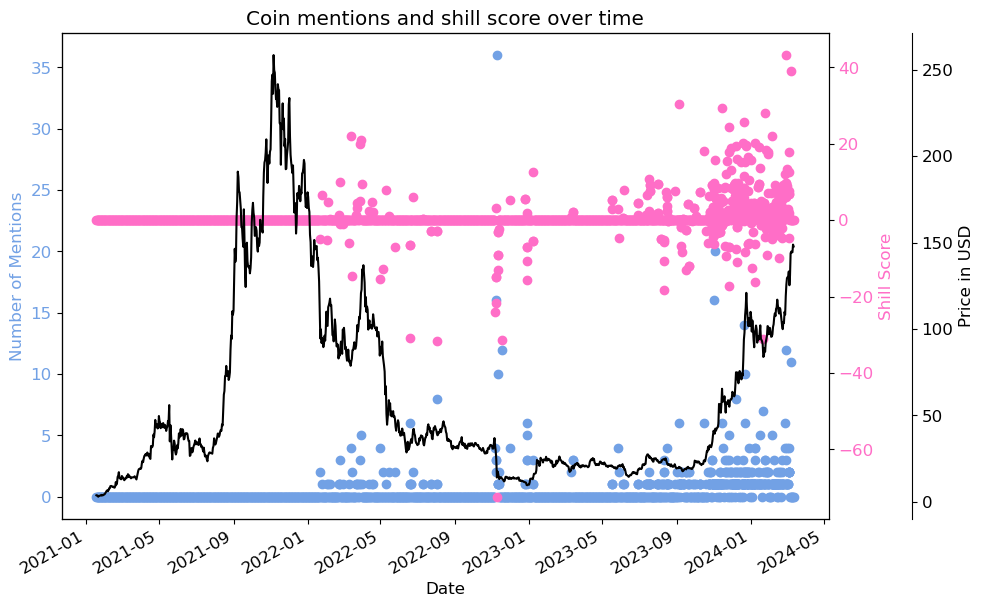

In [106]:
shill_chart(new_df)

### This is largely as expected, with sentiment and activity very bearish and active around November 2022, when FTX crashed, and both activity and sentiment picking up dramatically over summer 2023

### Now let's look at some histograms of average sentiment score and shill score over the period - sentiment is normally distributed and there appears to be positive correlation with momentum based technical metrics like RSI

Text(0.5, 1.0, 'Histogram of average sentiment score')

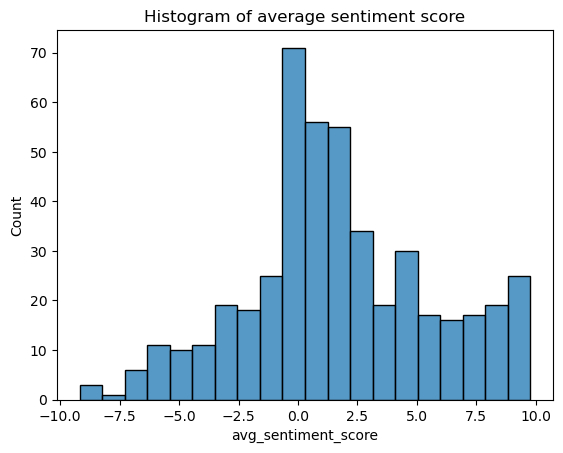

In [59]:
new_df_notna = new_df[new_df['coin_mentions'].notna()]
new_df_notna.head()

sns.histplot(new_df_notna['avg_sentiment_score'], bins=20)
plt.title('Histogram of average sentiment score')

In [60]:
new_df.corr()['14d_rtn'].sort_values(ascending=False)

14d_rtn                       1.000000
7d_rtn                        0.756030
10_20_ema                     0.232843
BB_Width                      0.224483
5_10_ema                      0.218517
14d_RSI                       0.177857
7d_RSI                        0.146620
AO                            0.134075
AC_CVD                        0.116588
3d_change_CVD                 0.112308
P_vs_upper                    0.082425
10_20_acc                     0.072564
z_score_3d_change_CVD         0.041162
AO_shill                      0.029431
34d_sma_shill                 0.023644
5d_sma_shill                  0.022832
z_score_3d_change_shill       0.022737
5_10_acc                      0.020396
shill_score                   0.019672
24h_volume                    0.019605
shill_score_7d_ema            0.019109
AC                            0.012947
log_shill_score               0.009394
avg_sentiment_score          -0.000854
avg_sentiment_score_7d_ema   -0.017363
num_mentions             

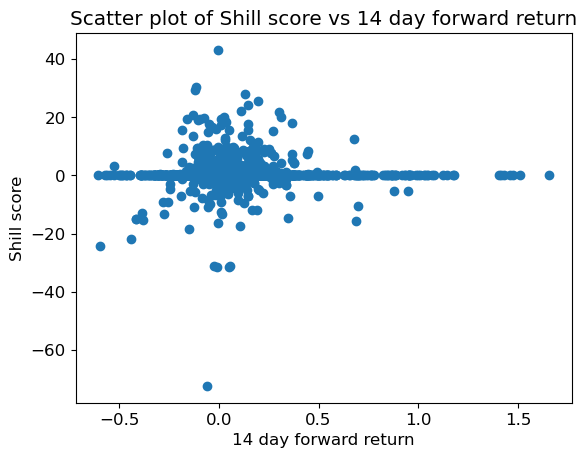

In [107]:
plt.scatter(new_df['14d_rtn'], new_df['shill_score'])
plt.title('Scatter plot of Shill score vs 14 day forward return')
plt.xlabel('14 day forward return')
plt.ylabel('Shill score')
plt.savefig('scatter_shill_14d.png')
plt.show()
          

### Let's look at correlations between 14d_rtn and Shill score, 7 day average Shill score and 7 day average sentiment for the top 15 coins

In [63]:
excluded_tickers = ['usdt', 'steth', 'usdc', 'wbtc', 'icp', 'dai', 'okb', 'ton', 'leo']
coins_list_ex_usdt = coins_list[~coins_list['Ticker'].isin(excluded_tickers)][:15]


df = pd.DataFrame(columns = ['coin', 'corr_shill', 'corr_shill_7', 'corr_sent_7'])

for coin in coins_list_ex_usdt['Ticker'].str.upper():
    print(coin)
    new_coin_df = coin_df(1150, coin)
    new_coin_df['shill_score_7d_ema'] = new_coin_df['shill_score_7d_ema'].fillna(0)
    new_coin_df['avg_sentiment_score_7d_ema'] = new_coin_df['avg_sentiment_score_7d_ema'].fillna(0)
        
    correl_value = new_coin_df.corr()['14d_rtn']['shill_score']

    correl_value_7 = new_coin_df.corr()['14d_rtn']['shill_score_7d_ema']
    
    correl_value_sent = new_coin_df.corr()['14d_rtn']['avg_sentiment_score_7d_ema']

    df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)
    
df
    
    
    

BTC


/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_59117/513800834.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)


ETH


/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_59117/513800834.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)


BNB


/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_59117/513800834.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)


SOL


/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_59117/513800834.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)


XRP


/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_59117/513800834.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)


ADA


/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_59117/513800834.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)


AVAX


/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_59117/513800834.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)


DOGE


/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_59117/513800834.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)


LINK


/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_59117/513800834.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)


TRX


/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_59117/513800834.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)


DOT


/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_59117/513800834.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)


MATIC


/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_59117/513800834.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)


SHIB


/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_59117/513800834.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)


LTC


/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_59117/513800834.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)


UNI


/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_59117/513800834.py:19: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)


,coin,corr_shill,corr_shill_7,corr_sent_7
0,BTC,0.002870,0.019704,0.001906
1,ETH,-0.002198,0.008711,-0.012608
2,BNB,0.008070,0.013676,0.016994
3,SOL,0.019689,0.019202,-0.017268
4,XRP,0.015525,0.025581,0.029223
5,ADA,-0.002182,-0.014964,-0.009289
6,AVAX,0.016490,0.030970,0.039445
7,DOGE,-0.013704,-0.027661,-0.035419
8,LINK,0.036293,0.079630,0.078353
9,TRX,0.001420,0.000746,-0.015390


### So we can see there is generally some positive correlation for most coins, but it's very weak, if negligible. 

### I then tried a list of more 'crypto native' coins which would likely have stronger community and more social media engagement.

In [64]:
excluded_tickers = ['usdt', 'steth', 'usdc', 'wbtc', 'icp', 'dai', 'okb', 'ton', 'leo']
coins_list_ex_usdt = coins_list[~coins_list['Ticker'].isin(excluded_tickers)][:15]



community_tickers = ['sol', 'doge', 'shib', 'rndr', 'aave', 'op', 'arb', 'beam', 'pepe', 'fil', 'fxs', 'rune', 'tia']
coins_list_degen = coins_list[coins_list['Ticker'].isin(community_tickers)]
coins_list_degen



,ID,Name,Ticker,Market Cap,24h Volume
4,solana,Solana,sol,41408261036,1.640421e+09
10,dogecoin,Dogecoin,doge,11211778444,2.700287e+08
18,shiba-inu,Shiba Inu,shib,5245572429,7.371245e+07
26,optimism,Optimism,op,3100916994,2.451138e+08
32,celestia,Celestia,tia,2874542858,1.046659e+08
37,filecoin,Filecoin,fil,2522880796,9.313445e+07
40,arbitrum,Arbitrum,arb,2312356828,3.229918e+08
48,render-token,Render,rndr,1649125299,1.084782e+08
56,thorchain,THORChain,rune,1322745447,2.141719e+08
58,aave,Aave,aave,1233123052,1.126713e+08


In [65]:
df = pd.DataFrame(columns = ['coin', 'corr_shill', 'corr_shill_7', 'corr_sent_7'])

for coin in coins_list_degen['Ticker'].str.upper():
    print(coin)
    new_coin_df = coin_df(1150, coin)
    new_coin_df['shill_score_7d_ema'] = new_coin_df['shill_score_7d_ema'].fillna(0)
    new_coin_df['avg_sentiment_score_7d_ema'] = new_coin_df['avg_sentiment_score_7d_ema'].fillna(0)
        
    correl_value = new_coin_df.corr()['14d_rtn']['shill_score']

    correl_value_7 = new_coin_df.corr()['14d_rtn']['shill_score_7d_ema']
    
    correl_value_sent = new_coin_df.corr()['14d_rtn']['avg_sentiment_score_7d_ema']

    df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)
    #df = df.append({'coin': coin, 'corr_shill': correl_value}, ignore_index=True)
df




SOL


/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_59117/1273919600.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)


DOGE


/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_59117/1273919600.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)


SHIB


/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_59117/1273919600.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)


OP


/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_59117/1273919600.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)


TIA


/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_59117/1273919600.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)


FIL


/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_59117/1273919600.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)


ARB


/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_59117/1273919600.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)


RNDR


/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_59117/1273919600.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)


RUNE


/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_59117/1273919600.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)


AAVE


/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_59117/1273919600.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)


BEAM


/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_59117/1273919600.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)


FXS


/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_59117/1273919600.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)


PEPE


/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/stevegoulden/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/2x/dbnt23xd6xv5bzc9snn0s0tm0000gn/T/ipykernel_59117/1273919600.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({'coin': coin, 'corr_shill': correl_value, 'corr_shill_7': correl_value_7, 'corr_sent_7': correl_value_sent}, ignore_index=True)


,coin,corr_shill,corr_shill_7,corr_sent_7
0,SOL,0.019685,0.019182,-0.017288
1,DOGE,-0.013702,-0.027659,-0.035416
2,SHIB,-0.026717,-0.077008,-0.089556
3,OP,0.092621,0.182522,0.153831
4,TIA,-0.162564,-0.317011,-0.494149
5,FIL,-0.000609,-0.035457,0.007238
6,ARB,-0.074512,-0.171221,-0.085708
7,RNDR,0.048048,0.081832,0.079160
8,RUNE,0.028306,0.027723,0.018621
9,AAVE,0.017357,0.064524,0.047351


### The results were frankly fairly mixed. Overall, I don't think there is enough evidence to say there is any conclusive signal from the initial correlation analysis alone.

## Modelling

### I tried working with regression models, in particular random forests, but the models were extremely overfit with a negative R squared on test data.

As this is a time series problem, we need to split the dataset in a non-shuffled manner to avoid the model learning from future data. So I did a 95% train/test split, which basically leaves me with around 2 months of test data. When we do this the results are very weak. We could be more robust here and do a multifold train/test split as I do in the k-means approach later but I thought as the initial results were so weak, it wasn't worth the time. I tried this for a number of other coins and got similar results. Here we have limited the analysis to SOL given API limits.

In [66]:
features = ['num_mentions', 'avg_sentiment_score', 'shill_score', '10_20_ema', '10_20_acc', '5_10_ema', '5_10_acc', '14d_RSI', 'AO', 'AC', 'AC_CVD', 
           'shill_score_7d_ema', 'avg_sentiment_score_7d_ema', 'num_mentions_7d_ema', 'AO_shill']


X = new_df[:-7][features]
y = new_df[:-7]['7d_rtn']

In [67]:
X=X.fillna(0)
X.isnull().sum()

num_mentions                  0
avg_sentiment_score           0
shill_score                   0
10_20_ema                     0
10_20_acc                     0
5_10_ema                      0
5_10_acc                      0
14d_RSI                       0
AO                            0
AC                            0
AC_CVD                        0
shill_score_7d_ema            0
avg_sentiment_score_7d_ema    0
num_mentions_7d_ema           0
AO_shill                      0
dtype: int64

In [68]:
len(new_df)

1408

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.05, shuffle=False)

In [70]:
ss = StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

In [71]:
rf = RandomForestRegressor()
rf.fit(X_train_ss, y_train)
#cross_val_score(rf, X_train_ss, y_train, cv=5).mean()
rf.score(X_test_ss, y_test)

-0.5434057032548625

In [72]:
feature_imp = pd.Series(rf.feature_importances_, index=X.columns)
feature_imp.sort_values(ascending=False)

AO                            0.168078
5_10_ema                      0.133313
10_20_ema                     0.110870
AC                            0.101666
14d_RSI                       0.097730
10_20_acc                     0.081083
AC_CVD                        0.068188
5_10_acc                      0.065609
avg_sentiment_score_7d_ema    0.055602
num_mentions_7d_ema           0.039068
AO_shill                      0.032950
shill_score_7d_ema            0.029276
shill_score                   0.007095
avg_sentiment_score           0.005568
num_mentions                  0.003904
dtype: float64

In [73]:
svr = SVR()
svr.fit(X_train, y_train)
svr.score(X_test, y_test)

-0.18555692180986316

In [74]:
preds = rf.predict(X_test_ss)

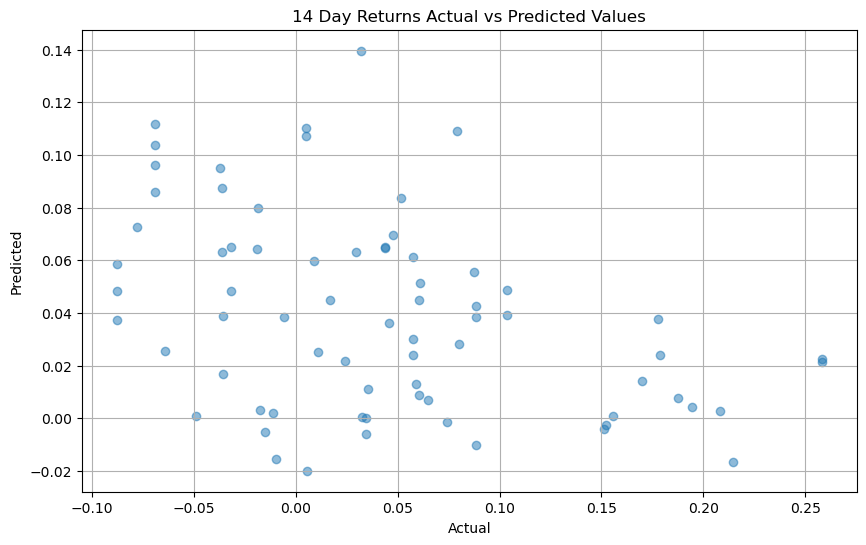

In [82]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, preds, alpha=0.5)

plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('14 Day Returns Actual vs Predicted Values')
plt.grid(True)
plt.savefig('rf_scatter.png')
plt.show()

In [83]:
#calculating hit rate of the above - in this case >50% but overall the results are 

actual_wl = np.where(y_test>0,1,-1)
preds_wl = np.where(preds>0,1,-1)

matches = actual_wl==preds_wl

accuracy = matches.mean()
accuracy

0.5915492957746479

### Although the results were inconclusive, I thought it was worth doing some SHAP (Shapley Additive Explanations) analysis. This essentially isolates the features, much like a random forest feature importance analysis.

In the summary plot, we can see how these features distribute, with high positive contributions in red and on the right hand side, and high negative in blue and on the left.

However, on closer analysis in the individual charts below, there does seem to be some positive correlation between shill score and number of mentions and their respective SHAP values for the target variable (ie 14 day forward return), using a random forest regression approach. But again, this is somewhat limited.

In [78]:
import shap
import pandas as pd
import numpy as np
shap.initjs()

In [79]:
explainer = shap.Explainer(rf)

In [80]:
shap_values = explainer.shap_values(X)

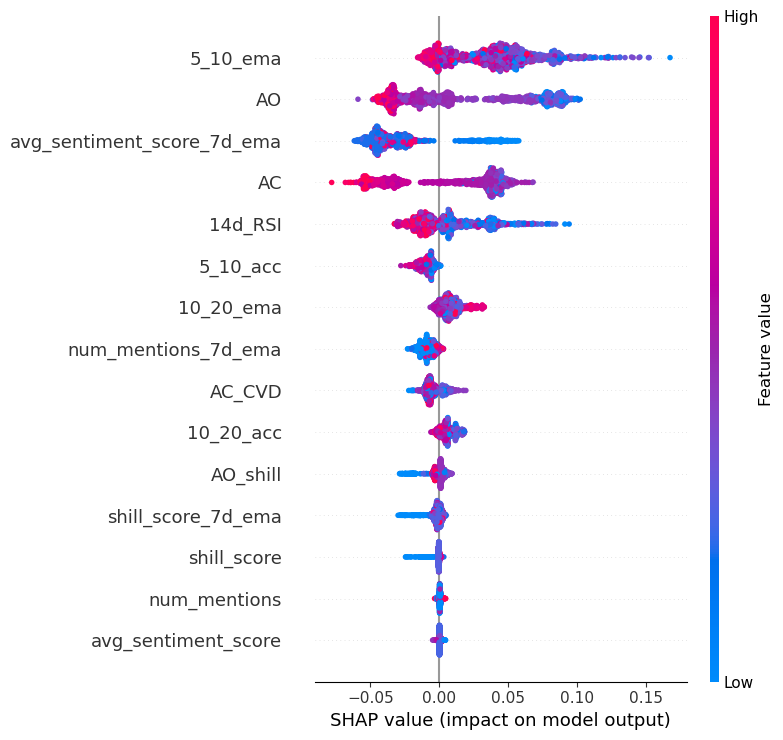

In [85]:
shap.summary_plot(shap_values, X)


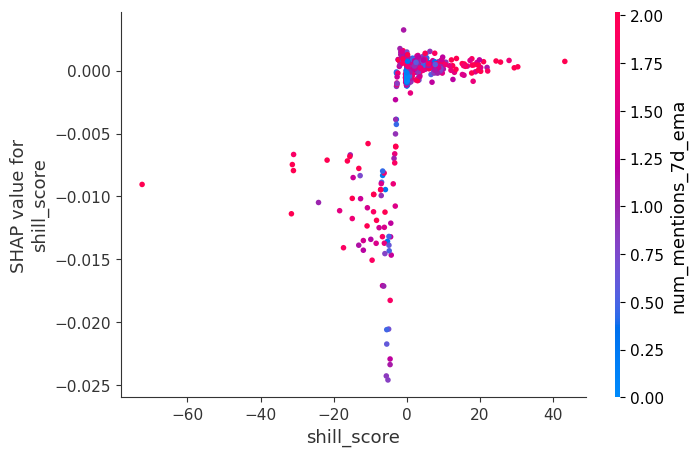

In [86]:
shap.dependence_plot("shill_score", shap_values, X) 

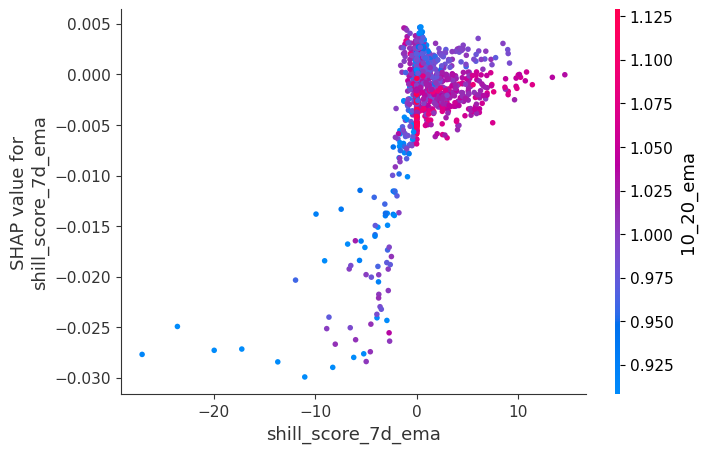

In [87]:
shap.dependence_plot("shill_score_7d_ema", shap_values, X) 

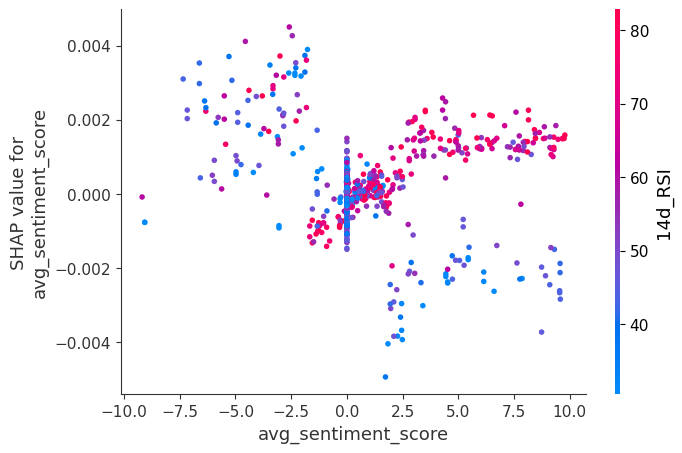

In [88]:
shap.dependence_plot("avg_sentiment_score", shap_values, X) 

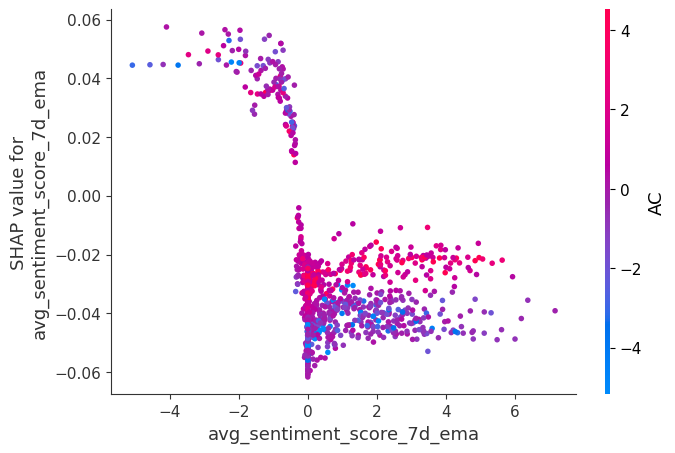

In [89]:
shap.dependence_plot("avg_sentiment_score_7d_ema", shap_values, X) 

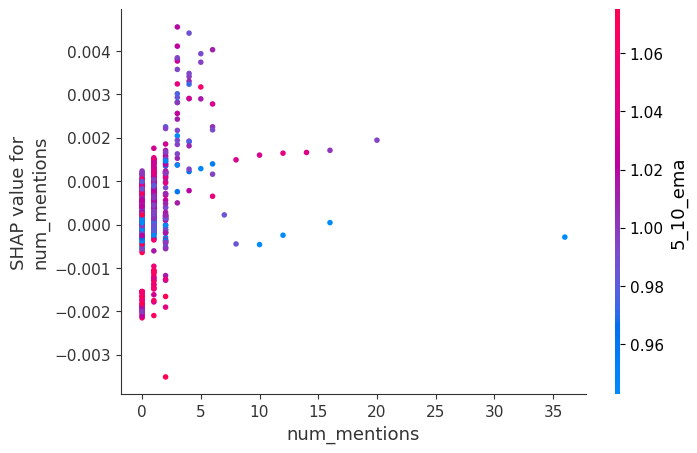

In [90]:
shap.dependence_plot("num_mentions", shap_values, X) 

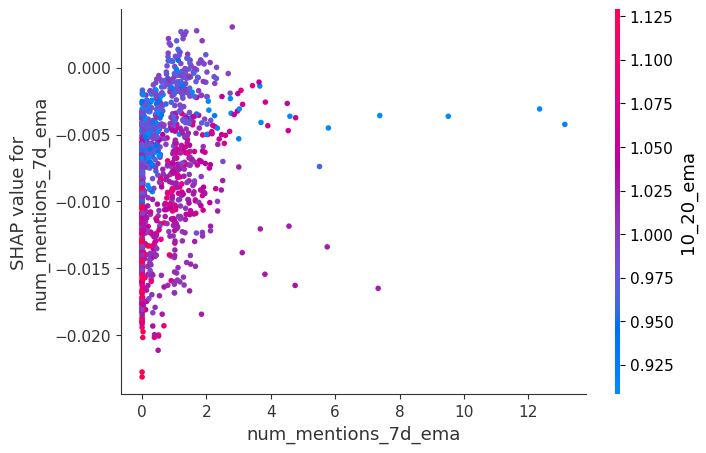

In [91]:
shap.dependence_plot("num_mentions_7d_ema", shap_values, X) 

#### So we can broadly conclude that there is very little predictive value in regression approaches, though there might be some limited predictive value in the shill score itself. 

Which led me to unsupervised learning. My thinking was that  individual features might not regress well - eg RSI works nicely during momentum runs, but then also precedes blow off tops and a high shill score could both precede a run but much more likely precede a top as the coin would be very well hyped and social media would be much more active - ie the incredibly high shill scores would be at market tops. In fact, looking at the Shap summary plot above, the highest sentiment scores tended to precede very weak 14 day returns. 

However there might well be clustered instances where the 'stars align' - for example let's say SOL in early October - at this point shill score is picking up, RSI is increasing but not elevated, volumes are meaningfully picking up with price increasing (and so CVD is increasing and AC_CVD is elevated), 10_20_ema is rising and 10_20_acc is high (signalling a turning of momentum). The telegram data might help us find an early 'heads up' from an increasingly engaged and positive community and so combining this data with technical indicators to specifically target this early break out category could possibly work.

Essentially we are looking for the stars to align across a number of metrics and k-means might be able to identify these clusters.

### K means

First I cluster excluding forward 14 day returns

In [108]:
features = ['num_mentions', 'avg_sentiment_score', 'shill_score', '10_20_ema', '10_20_acc', '14d_RSI', '3d_change_CVD', 'AO', 'AC_CVD',
           'shill_score_7d_ema', 'avg_sentiment_score_7d_ema', 'num_mentions_7d_ema', 'BB_Width', 'P_vs_lower']


ZZ = new_df[:-14][features]

ZZ=ZZ.fillna(0)
ZZ.isnull().sum()


num_mentions                  0
avg_sentiment_score           0
shill_score                   0
10_20_ema                     0
10_20_acc                     0
14d_RSI                       0
3d_change_CVD                 0
AO                            0
AC_CVD                        0
shill_score_7d_ema            0
avg_sentiment_score_7d_ema    0
num_mentions_7d_ema           0
BB_Width                      0
P_vs_lower                    0
dtype: int64

In [109]:
km = KMeans(n_clusters=5, random_state=42)
sc = StandardScaler()
ZZ_sc = sc.fit_transform(ZZ)
km.fit(ZZ_sc)

KMeans(n_clusters=5, random_state=42)

#### We used 5 clusters as our optimised level. We discuss this in the PCA section and arriaved at this using silhouette and inertia scores.

In [110]:
from sklearn.metrics import silhouette_score
silhouette_score(ZZ_sc, km.labels_)

0.3381212776006962

In [111]:
ZZ_1 = ZZ.copy()
ZZ_1['labels'] = km.labels_

In [112]:
ZZ_1['labels'].value_counts()

3    885
2    271
1    214
0     20
4      4
Name: labels, dtype: int64

In [113]:
new_df.tail()

,date,price,24h_volume,coin_mentions,num_mentions,avg_sentiment_score,shill_score,20d_ema,10d_ema,5d_ema,...,Upper_Band,Lower_Band,BB_Width,P_vs_upper,P_vs_lower,14d_rtn,7d_rtn,shill_score_7d_ema,avg_sentiment_score_7d_ema,num_mentions_7d_ema
1403,2024-03-08,144.79,8096745.65,NaN,0.0,0.0,0.0,128.175355,132.920654,136.970235,...,141.067286,118.302714,0.175537,1.026390,0.817064,NaN,NaN,11.385391,2.469900,3.052341
1404,2024-03-09,144.29,3686876.81,NaN,0.0,0.0,0.0,129.710083,134.987808,139.410157,...,143.555381,117.675619,0.198137,1.005117,0.815549,NaN,NaN,8.539043,1.852425,2.289256
1405,2024-03-10,144.39,4489519.25,NaN,0.0,0.0,0.0,131.108170,136.697298,141.070104,...,145.642558,117.459442,0.214237,0.991400,0.813487,NaN,NaN,6.404283,1.389319,1.716942
1406,2024-03-11,148.83,7743384.35,NaN,0.0,0.0,0.0,132.795963,138.903243,143.656736,...,148.473325,116.943675,0.237586,1.002402,0.785753,NaN,NaN,4.803212,1.041989,1.287706
1407,2024-03-12,147.71,5502814.33,NaN,0.0,0.0,0.0,134.216348,140.504472,145.007824,...,150.555118,117.064882,0.250282,0.981102,0.792532,NaN,NaN,3.602409,0.781492,0.965780


#### I then add back 14 day returns from the original dataset, so that we can understand the return profiles of the various clusters. We can see a significant difference in the return profiles, which I show in the boxplots across features below ('14d_rtn column')

In [114]:
ZZ_1['14d_rtn'] = new_df['14d_rtn'][:-14]
#Adding new lines
ZZ_1['date'] = new_df['date'][:-14]
ZZ_1['price'] = new_df['price'][:-14]

In [115]:
ZZ_1.tail()

,num_mentions,avg_sentiment_score,shill_score,10_20_ema,10_20_acc,14d_RSI,3d_change_CVD,AO,AC_CVD,shill_score_7d_ema,avg_sentiment_score_7d_ema,num_mentions_7d_ema,BB_Width,P_vs_lower,labels,14d_rtn,date,price
1389,1.0,8.817323,8.817323,1.045417,1.007448,78.627082,8376631.09,15.251176,5025978.654,9.791798,5.070346,2.480731,0.396010,0.692391,1,0.118674,2024-03-01,129.43
1390,4.0,3.355824,13.423297,1.046441,1.004858,78.627082,8376631.09,15.634706,3350652.436,10.699673,4.641716,2.860548,0.415156,0.690591,1,0.114811,2024-03-01,129.43
1391,1.0,2.929677,2.929677,1.046715,1.002712,79.131662,4693251.94,16.118882,5429927.770,8.757174,4.213706,2.395411,0.426467,0.690112,1,0.110521,2024-03-02,130.02
1392,1.0,1.357161,1.357161,1.046036,1.000529,79.131662,4693251.94,16.603059,2815951.164,6.907171,3.499570,2.046558,0.432420,0.695033,1,0.144670,2024-03-02,130.02
1393,1.0,2.391796,2.391796,1.044780,0.998950,79.266368,9921622.80,16.259059,6059997.464,5.778327,3.222626,1.784919,0.433799,0.701235,1,0.134834,2024-03-03,130.16


In [116]:
ZZ_1.groupby('labels').mean().sort_values(by='14d_rtn', ascending=False)

,num_mentions,avg_sentiment_score,shill_score,10_20_ema,10_20_acc,14d_RSI,3d_change_CVD,AO,AC_CVD,shill_score_7d_ema,avg_sentiment_score_7d_ema,num_mentions_7d_ema,BB_Width,P_vs_lower,14d_rtn,price
labels,,,,,,,,,,,,,,,,
4,0.000000,0.000000,0.000000,0.992595,0.000000,11.522846,-1.088230e+06,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.586552,3.530500
2,0.188192,-0.051796,-0.076343,1.091124,1.005549,72.121823,6.604459e+06,14.279765,4.389730e+06,0.245225,0.170772,0.214084,0.667994,0.501504,0.242255,63.201227
1,1.803738,4.338733,6.827845,1.025890,1.000709,65.513034,2.281678e+06,5.495053,1.431438e+06,4.601981,3.070568,1.574415,0.251174,0.831781,0.057066,77.680514
3,0.285876,-0.085758,-0.236331,0.980672,0.998758,45.943714,-7.860837e+05,-3.783311,-5.056154e+05,0.027368,0.112490,0.368381,0.313388,0.881752,0.019010,55.825186
0,6.300000,-3.813116,-17.861831,0.913460,0.980196,33.845291,-1.019206e+07,-5.929429,-6.518203e+06,-10.937766,-2.515392,4.484312,0.711419,0.858068,-0.092995,23.435000


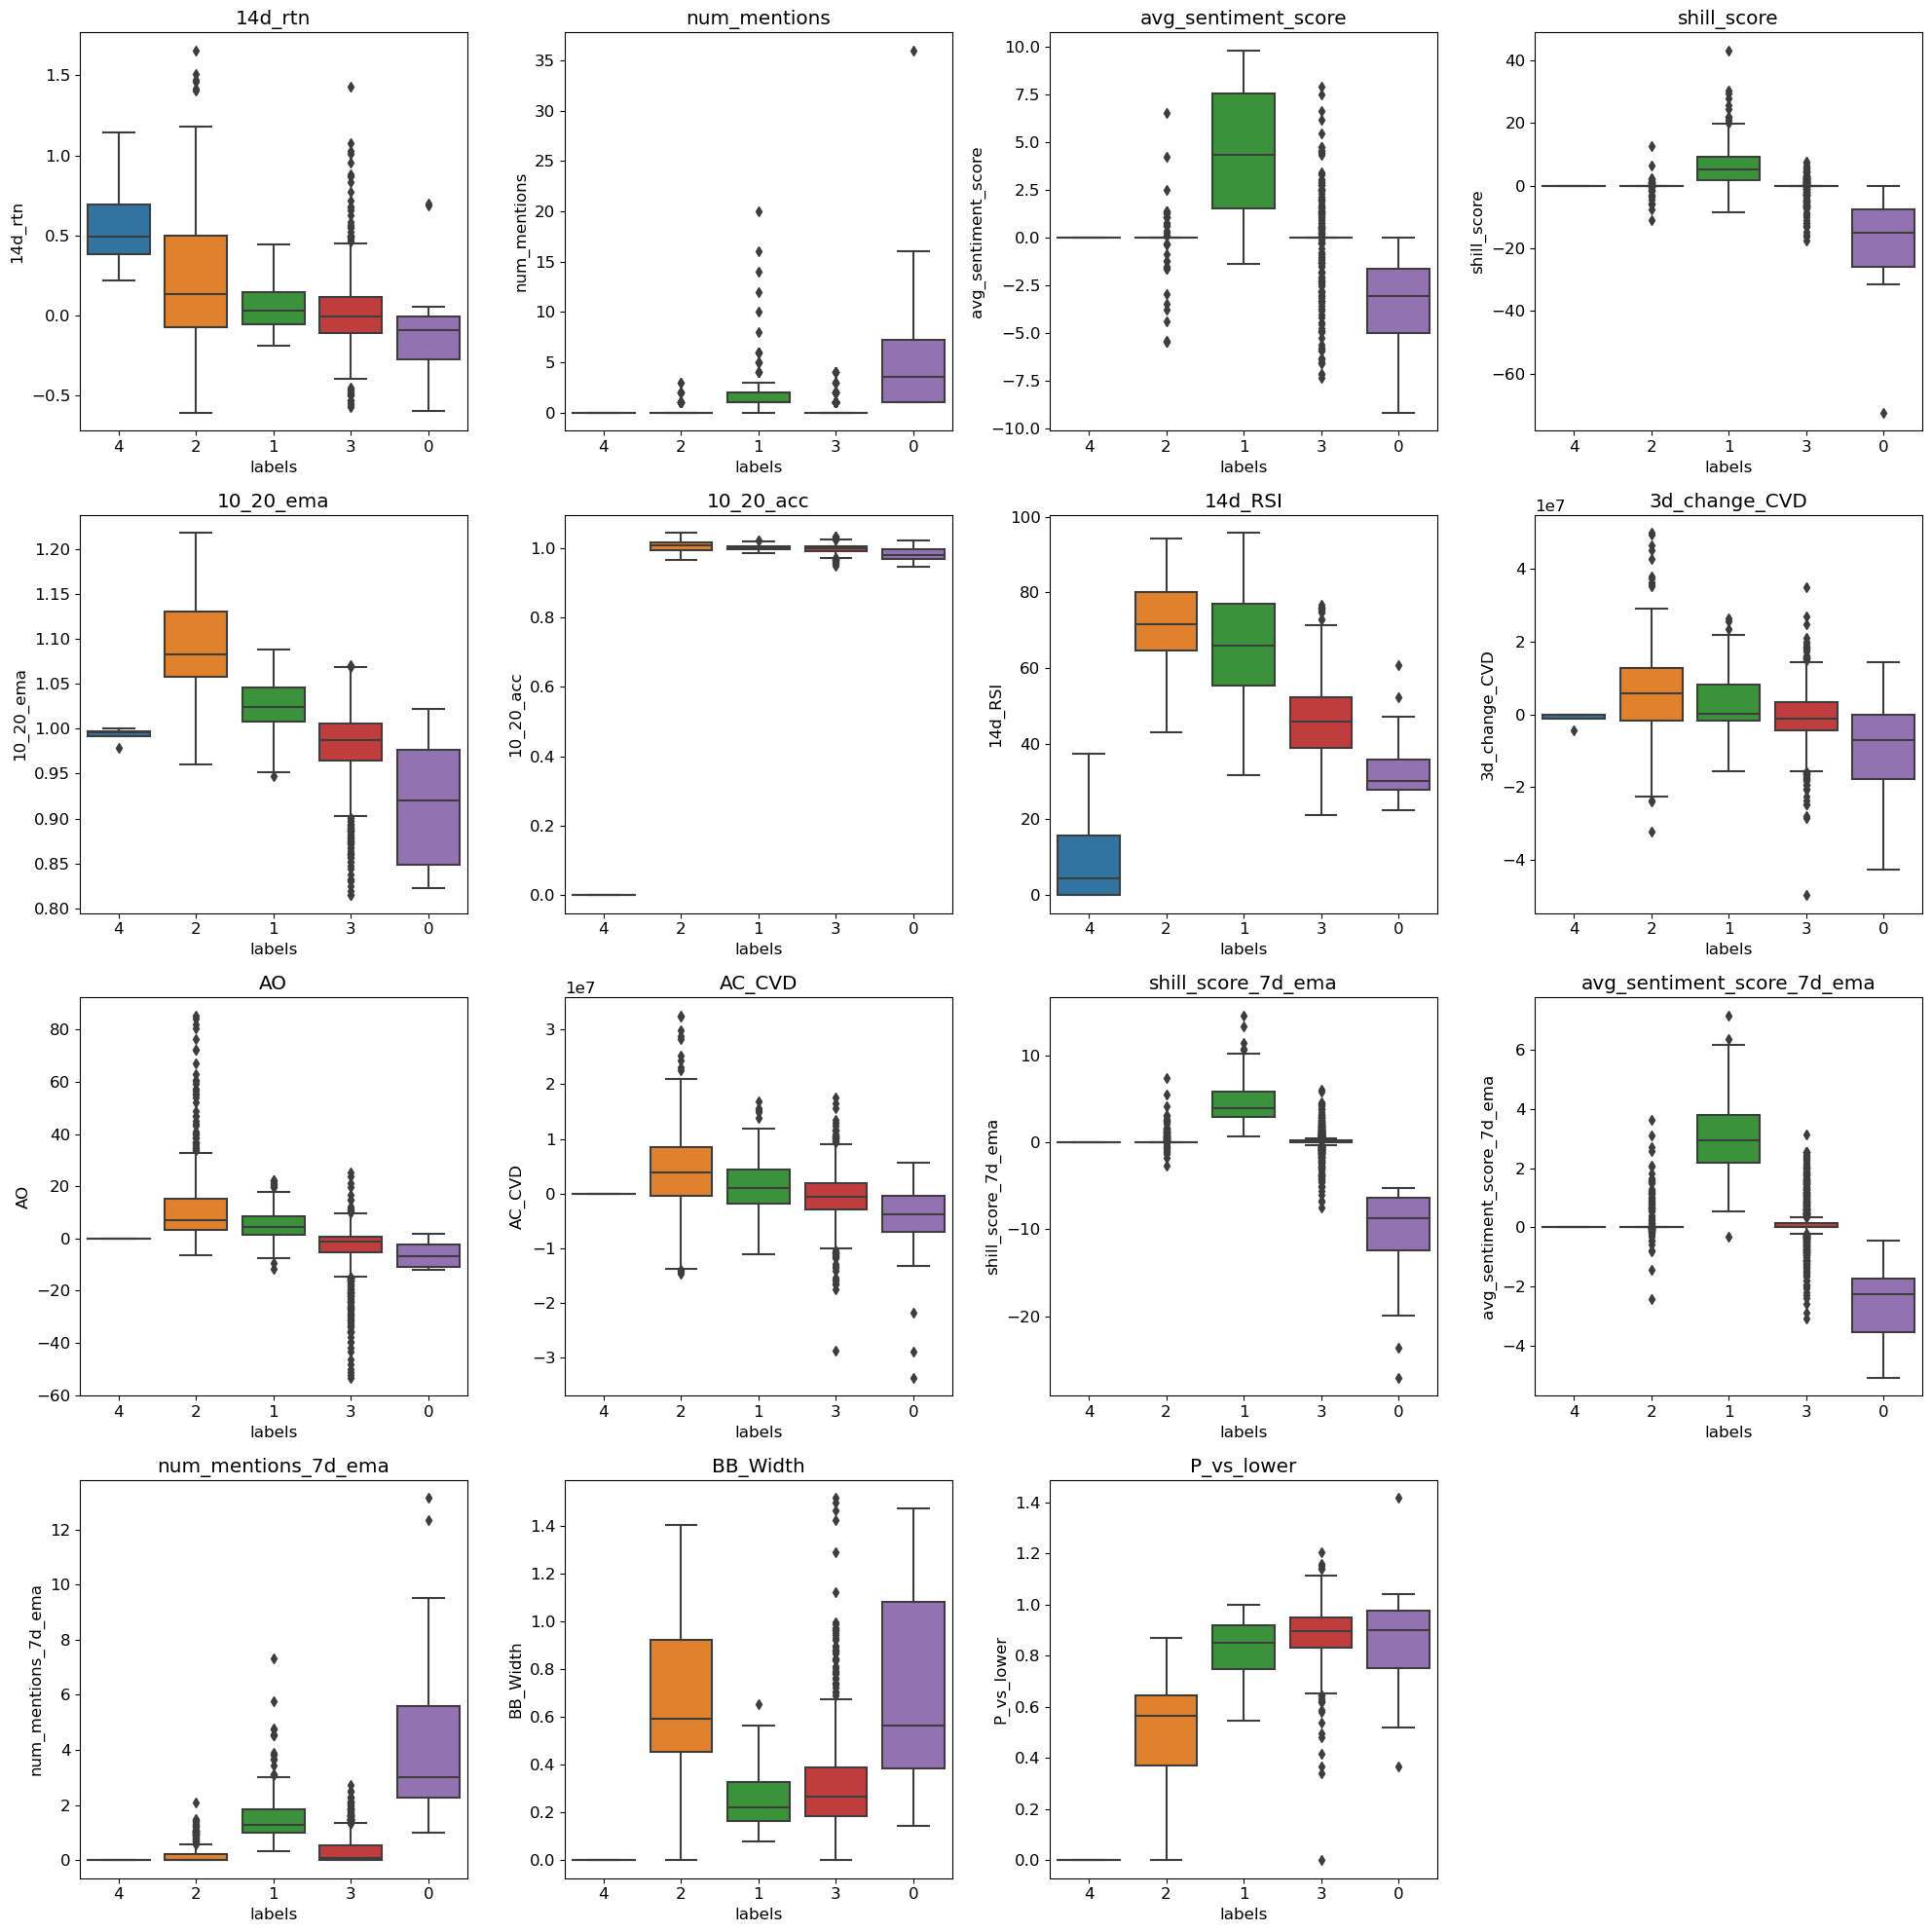

In [230]:
#producing charts

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({'font.size': 12})

average_14d_rtn_per_cluster = ZZ_1.groupby('labels')['14d_rtn'].mean().sort_values(ascending=False)

features_for_plotting = ['14d_rtn', 'num_mentions', 'avg_sentiment_score', 'shill_score', '10_20_ema', '10_20_acc', '14d_RSI', '3d_change_CVD', 'AO', 'AC_CVD',
           'shill_score_7d_ema', 'avg_sentiment_score_7d_ema', 'num_mentions_7d_ema', 'BB_Width', 'P_vs_lower']

plt.figure(figsize=(20, 20))

cluster_order = average_14d_rtn_per_cluster.index.tolist()

for i, feature in enumerate(features_for_plotting, 1):
    plt.subplot(4, 4, i)
    sns.boxplot(x='labels', y=feature, data=ZZ_1, order=cluster_order)
    plt.title(feature)

plt.tight_layout()
plt.savefig('sol_boxplots.png')
plt.show()

The charts above show that there appears to be a weakly positive return to average sentiment and shill score. 

Other than for cluster 4, which only fired 4 times and is a deep value/oversold cluster, momentum features are very highly correlated - ie 14d RSI, 10_20_ema (10day ema/ 20 day) and 10_20_acc (daily 10_20_ema / its own 5 dma), with this latter feature a metric for detecting changes in trend. 

This is in part due to using SOL as an example- SOL is a fairly momentum driven name, especially over the last few months, but the principal tends to hold across the crypto space more generally.

### Below, we use this approach to identify the latest cluster, which could be used as a trading signal. 

In [118]:

features_for_prediction = ['num_mentions', 'avg_sentiment_score', 'shill_score', '10_20_ema', '10_20_acc', '14d_RSI', '7d_RSI', '3d_change_CVD', 'z_score_3d_change_CVD', 'AO', 'AC', 'AC_CVD', 'z_score_3d_change_shill', 'log_shill_score',
                          'shill_score_7d_ema', 'avg_sentiment_score_7d_ema', 'num_mentions_7d_ema']

most_recent_data = new_df.tail(1)[features]

most_recent_data = most_recent_data.fillna(0)

most_recent_data_sc = sc.fit_transform(most_recent_data)

cluster_label = km.predict(most_recent_data_sc)

print("The cluster label for the most recent data is:", cluster_label)

The cluster label for the most recent data is: [3]


In [119]:
ZZ_2 = ZZ_1.copy()
ZZ_2.head()

,num_mentions,avg_sentiment_score,shill_score,10_20_ema,10_20_acc,14d_RSI,3d_change_CVD,AO,AC_CVD,shill_score_7d_ema,avg_sentiment_score_7d_ema,num_mentions_7d_ema,BB_Width,P_vs_lower,labels,14d_rtn,date,price
0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.00,0.0,0.000,0.0,0.0,0.0,0.0,0.0,4,0.218654,2021-01-18,3.7868
1,0.0,0.0,0.0,0.996371,0.000000,0.000000,0.00,0.0,0.000,0.0,0.0,0.0,0.0,0.0,4,0.442142,2021-01-19,3.6287
2,0.0,0.0,0.0,0.995759,0.000000,37.450927,0.00,0.0,0.000,0.0,0.0,0.0,0.0,0.0,4,0.542028,2021-01-20,3.7166
3,0.0,0.0,0.0,0.978252,0.000000,8.640458,-4352918.11,0.0,0.000,0.0,0.0,0.0,0.0,0.0,4,1.143383,2021-01-21,2.9899
4,0.0,0.0,0.0,0.973584,0.984618,34.446003,6897304.31,0.0,3520611.106,0.0,0.0,0.0,0.0,0.0,3,1.009025,2021-01-22,3.3352


### Now that we have a clustering approach, we can see the historical performance of those clusters over time. 

I used a strategy of buying on the cluster trigger at the close of that day and holding for 14 days, or cutting at a trade stop loss of 10%. If the trigger fires again during the trade, the holding period is reset.

In [231]:
def label_return_final(df):

    df['log_price'] = np.log(df['price'])
    df['log_rtn'] = df['log_price'].diff()

    
    summary_df = pd.DataFrame(columns=['Cluster', 'Count', 'Hit Rate', 'Mean', 'Std', 'Min', '50%', 'Max'])

    # Parameters for the strategy
    holding_period = 14
    stop_loss = 0.10  # 10%
    
    fig, ax1 = plt.subplots(figsize=(14, 8))  
    colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange', 4: 'pink'}


    for label in df['labels'].unique():
        df['trigger'] = np.where(df['labels'] == label, 1, 0)
        df['stance'] = 0
        df['in_trade'] = False
        df['trade_entry_price'] = None
        df['in_trade_rtn'] = 0
        df['14d_rtn'] = 0
        df['14d_fwd_rtn'] = 0
        
        for i in range(len(df) - holding_period -1):
            if df.loc[i, 'trigger'] == 1 and not df.loc[i, 'in_trade']:
                df.loc[i+1, 'in_trade'] = True
                df.loc[i + 1, 'stance'] = 1
                df.loc[i, 'trade_entry_price'] = df.loc[i, 'price']
                
                df.loc[i+holding_period, '14d_fwd_rtn'] = (df.loc[i+holding_period, 'price'] / df.loc[i, 'price'])-1
                
                for j in range(i + 1, i + holding_period + 1):
                    df.loc[j, 'stance'] = 1
                    df.loc[j, 'in_trade'] = True
                    df.loc[j, 'trade_entry_price'] = df.loc[i, 'trade_entry_price']

                    df.loc[j, 'in_trade_rtn'] = (df.loc[j, 'price'] / df.loc[i, 'trade_entry_price']) - 1
                    if df.loc[j, 'in_trade_rtn'] < -stop_loss or (j - i) == holding_period:
                        df.loc[j + 1, 'trigger'] = -1
                        df.loc[j + 1, 'stance'] = 0
                        df.loc[j + 1, 'in_trade'] = False
                   
                        df.loc[i, 'trade_rtn'] = df.loc[j, 'price'] / df.loc[i, 'price']
                        break  # ie exit the trade loop when stop loss triggers or end of holding period
                        
            if df.loc[i, 'trigger'] == 1 and df.loc[i, 'in_trade']:
                df.loc[i+1, 'in_trade'] = True
                df.loc[i + 1, 'stance'] = 1
                df.loc[i, 'trade_entry_price'] = df.loc[i-1, 'trade_entry_price']
                df.loc[i+holding_period, '14d_fwd_rtn'] = (df.loc[i+holding_period, 'price'] / df.loc[i, 'price'])-1
                
                for j in range(i + 1, i + holding_period + 1):
                    df.loc[j, 'stance'] = 1
                    df.loc[j, 'in_trade'] = True
                    df.loc[j, 'trade_entry_price'] = df.loc[i, 'trade_entry_price']
                    
                    df.loc[j, 'in_trade_rtn'] = (df.loc[j, 'price'] / df.loc[i, 'trade_entry_price']) - 1
                    if df.loc[j, 'in_trade_rtn'] < -stop_loss or (j - i) == holding_period:
                        df.loc[j + 1, 'trigger'] = -1
                        df.loc[j + 1, 'stance'] = 0
                        df.loc[j + 1, 'in_trade'] = False
                        
                        df.loc[i, 'trade_rtn'] = df.loc[j, 'price'] / df.loc[i, 'price']
                        

                        break  
                        
        df['equity_log_return'] = np.where(df['stance'] == 1, df['log_rtn'], 0)
        df['cumulative_equity_return'] = df['equity_log_return'].cumsum().apply(np.exp)
    
        df['equity_curve'] = df['cumulative_equity_return']

        df['date'] = pd.to_datetime(df['date'])
        
        hit_rate = len(df[df['14d_fwd_rtn'] >0]['14d_rtn'])/len(df[df['14d_fwd_rtn'] !=0]['14d_fwd_rtn'])

        stats = df[df['14d_fwd_rtn'] !=0]['14d_fwd_rtn'].describe()

        summary_df.loc[len(summary_df)] = [
            label,
            stats['count'],
            hit_rate,
            stats['mean'],
            stats['std'],
            stats['min'],
            stats['50%'],
            stats['max']]


        ax1.plot(df['date'], df['cumulative_equity_return'], label=f'Cluster {label}', color=colors[label])   

        ax1.set_xlabel('Date')
        ax1.set_ylabel('Cumulative Equity Return')
        ax1.tick_params(axis='y')
        ax1.legend(loc='upper left')


    normalized_price = df['price'] / df['price'].iloc[0]

    ax2 = ax1.twinx() 
    ax2.set_ylabel('Normalized Price', color='black')  
    ax2.plot(df['date'], normalized_price, color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    for label in ax1.get_xticklabels():
        label.set_rotation(45)

    plt.tight_layout() 
    plt.title('Cumulative Equity Return and Normalized Price Over Time')
    plt.savefig('sol_cumulative.png')
    plt.show()    
    
    summary_sorted = summary_df.sort_values(by='Hit Rate', ascending=False)
    return summary_sorted
  


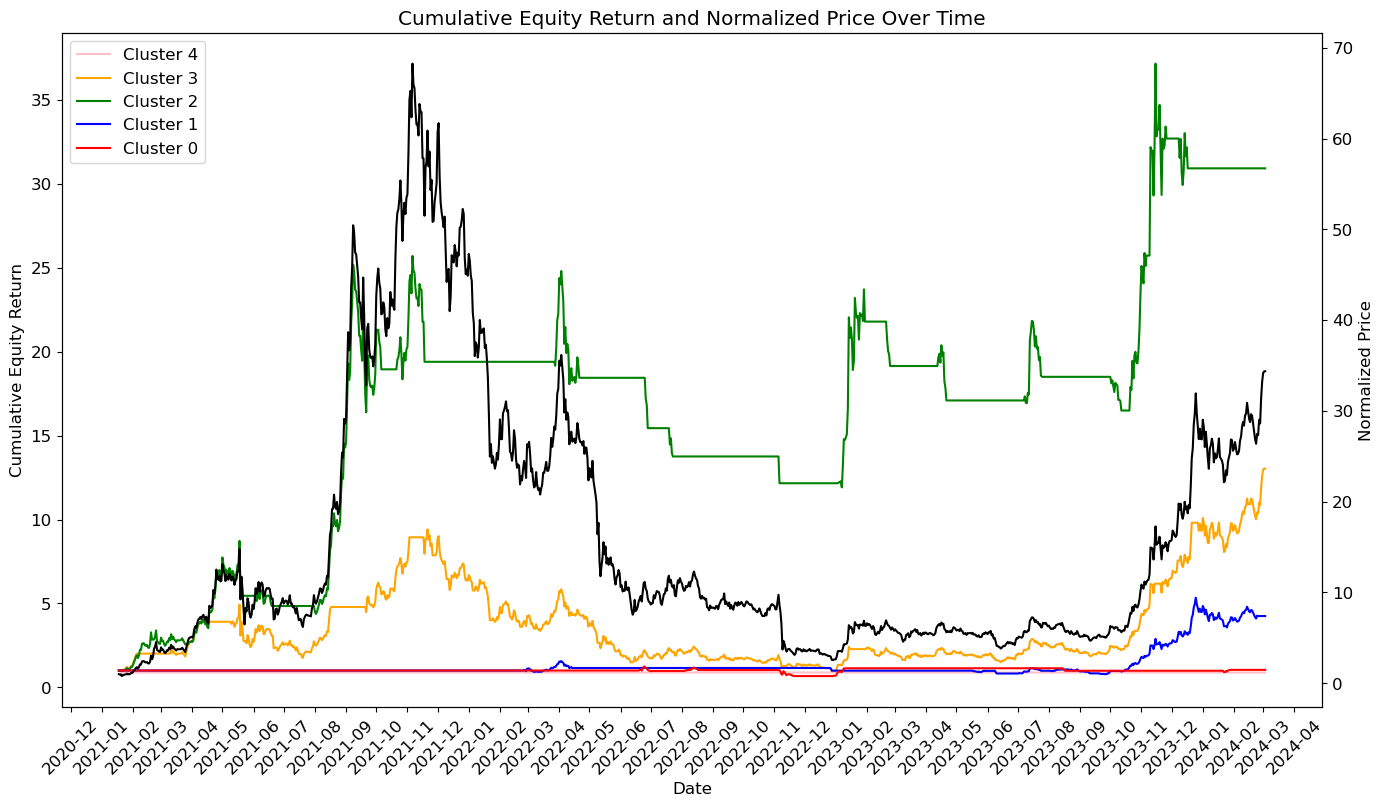

,Cluster,Count,Hit Rate,Mean,Std,Min,50%,Max
0,4.0,4.0,1.000000,0.586552,0.395072,0.218654,0.492085,1.143383
2,2.0,189.0,0.634921,0.209086,0.388830,-0.604878,0.104444,1.473469
3,1.0,142.0,0.549296,0.041612,0.139394,-0.186243,0.013499,0.444690
1,3.0,557.0,0.473968,0.018337,0.226347,-0.567872,-0.010791,1.426426
4,0.0,18.0,0.277778,-0.055838,0.321109,-0.595953,-0.047626,0.697095


In [232]:
label_return_final(ZZ_2)

Overall, the strategy works very well and we can see the individual buy signals in the chart below. The only cluster with a negative mean return is cluster 0 and this is marginal. The hit rates of the other clusters are generally above 50% and the stop loss prevents material drawdowns.

Note the table above is simply the 14 day return of each signal not the performance of the strategy.

The stand out cluster is cluster 1, which has delivered a return of ~30x since 2020, or roughly double the underlying return of SOL. We can see from the chart below that this cluster generally likes early momentum break outs and tends to stay invested for the majority of the trend. 

While the hit rate and mean return are better with cluster 4, cluster 1 fires far more often and so total retun is much higher. The minimum returns in the above table are much more aggressive due to being in more positions, but this is curtailed by the stop loss.

### Below, we can see the cluster signals generated over time

In [233]:
def buy_signals_over_time(df, k_means_df):
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)

    fig = plt.figure(figsize=(14, 7))


    ax1 = plt.gca() 
    ax1.plot(df['date'], df['price'], label='Price', color='black', linewidth=1)
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='black')
    ax1.tick_params(axis='y', labelcolor='black')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Label', color='black') 

    colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange', 4: 'pink'}

    for label, group in k_means_df.groupby('labels'):
        ax2.scatter(group['date'], [label]*len(group), color=colors[label], label=f'Label {label}', alpha=0.6, edgecolors='w')

    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.title('Buy Signals Over Time')
    plt.tight_layout()
    plt.savefig('sol_buy_signals.png')
    plt.show()

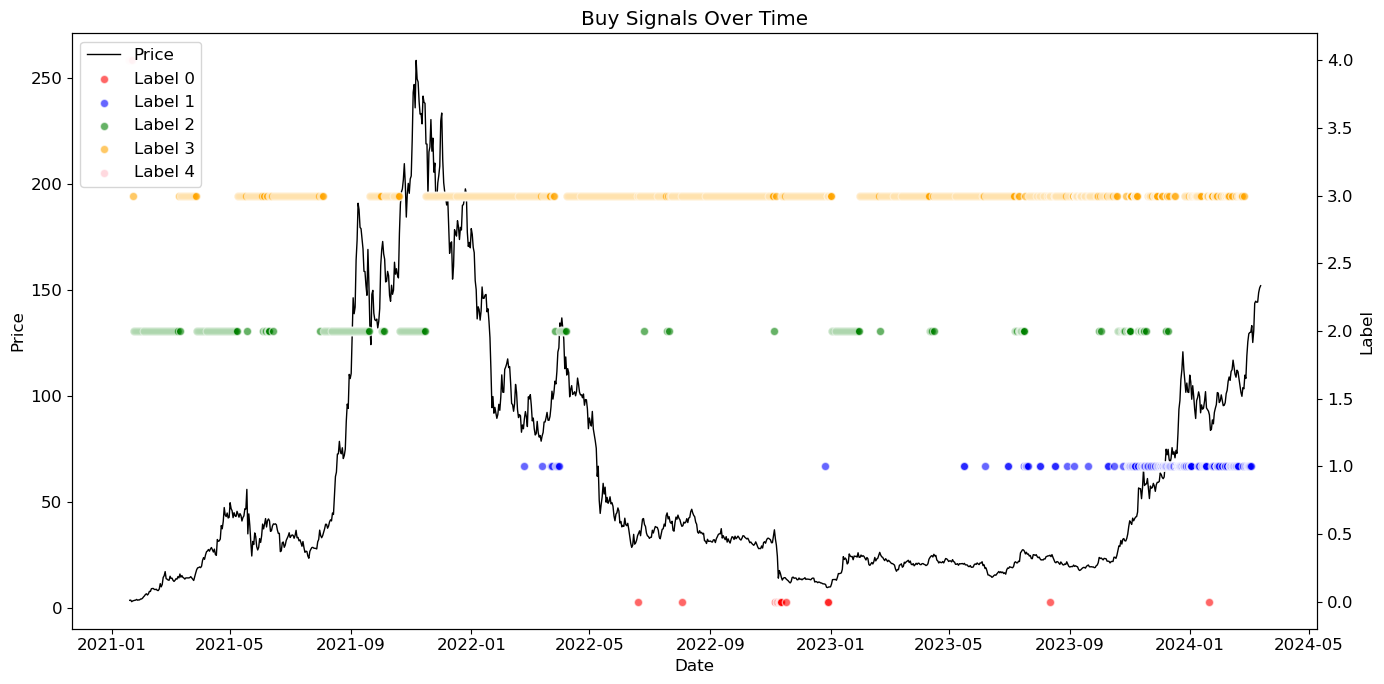

In [236]:
buy_signals_over_time(new_df, ZZ_2)

### Overall, this is an encouraging start. As a next step, I tried incorporating PCA. 
As we have 14 features, reducing this to principal components might improve the silhouette score, ie allow for tighter clustering across fewer dimensions and therefore lead to improved resuls through better classification.

#### In the approach below, I start by running PCA on the main dataframe and then look at the cumulative explained variance.
We can see that 4 PCs explain 70-80% of the variance and so we use this as our rule of thumb going forward. We also look at the elbow curve inertia for number of clusters in the k means algorithm. I chose 5 clusters as roughly optimal - ie this is where the'kink' is - improvement is limited beyond that given that we are trying to optimise the trade off between tightness and limiting the number of clusters. 



 
 # PCA and k-means

In [128]:
features = ['num_mentions', 'avg_sentiment_score', 'shill_score', '10_20_ema', '10_20_acc', '14d_RSI', '3d_change_CVD', 'AO', 'AC_CVD',
           'shill_score_7d_ema', 'avg_sentiment_score_7d_ema', 'num_mentions_7d_ema', 'BB_Width', 'P_vs_lower']


ZZ_pca = new_df[:-14][features]

ZZ_pca=ZZ_pca.fillna(0)
ZZ_pca.isnull().sum()

num_mentions                  0
avg_sentiment_score           0
shill_score                   0
10_20_ema                     0
10_20_acc                     0
14d_RSI                       0
3d_change_CVD                 0
AO                            0
AC_CVD                        0
shill_score_7d_ema            0
avg_sentiment_score_7d_ema    0
num_mentions_7d_ema           0
BB_Width                      0
P_vs_lower                    0
dtype: int64

In [129]:
scaler = StandardScaler()
segmentation_std = scaler.fit_transform(ZZ_pca)

In [130]:
pca = PCA(random_state=42)
pca.fit(segmentation_std)

PCA(random_state=42)

In [131]:
pca.explained_variance_ratio_

array([0.28028981, 0.21113109, 0.12832891, 0.11240121, 0.07526157,
       0.06623523, 0.03240236, 0.02426279, 0.02202872, 0.01970482,
       0.0131207 , 0.00740025, 0.00387959, 0.00355295])

Text(0, 0.5, 'Cumulative Explained Variance')

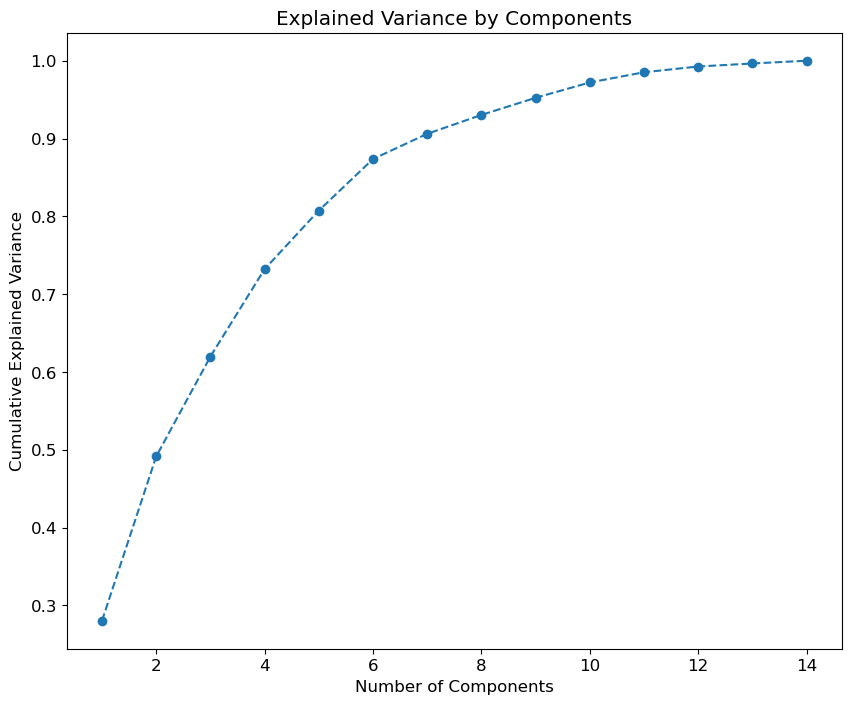

In [132]:
plt.figure(figsize= (10,8))
plt.plot(range(1,15), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [133]:
pca = PCA(n_components = 4, random_state=42)

In [134]:
pca.fit(segmentation_std)

PCA(n_components=4, random_state=42)

In [135]:
pca.transform(segmentation_std)

array([[ 2.13793874, -0.6023025 , -0.44770435, -4.82416348],
       [ 2.15975886, -0.59008387, -0.45834508, -4.80886854],
       [ 1.17460175, -0.92566147, -0.0429903 , -4.80416435],
       ...,
       [-3.90761934,  2.09215457,  1.2361549 ,  0.26279234],
       [-3.14881679,  1.28569032,  1.30734924,  0.04933419],
       [-3.41468613,  1.06263746,  0.87171723,  0.56644985]])

In [136]:
scores_pca = pca.transform(segmentation_std)

In [137]:
wcss = []
for i in range(1,18):
    kmeans_pca = KMeans(n_clusters = i, random_state = 42)
    kmeans_pca.fit(scores_pca)
    wcss.append(kmeans_pca.inertia_)

In [138]:
silhouette_scores = []
for i in range(2, 18):  # Silhouette score can only be computed for 2 or more clusters
    kmeans_pca = KMeans(n_clusters=i, random_state=42)
    kmeans_pca.fit(scores_pca)
    score = silhouette_score(scores_pca, kmeans_pca.labels_)
    silhouette_scores.append(score)

Text(0.5, 1.0, 'K-means with PCA Clustering')

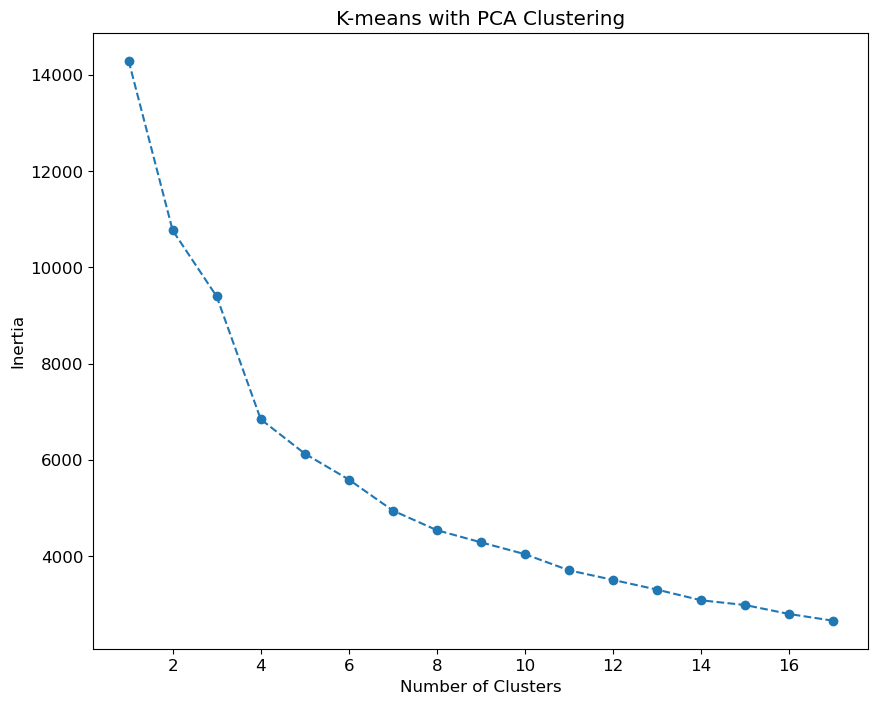

In [139]:
plt.figure(figsize= (10, 8))
plt.plot(range(1,18), wcss, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('K-means with PCA Clustering')

Text(0.5, 1.0, 'K-means with PCA Clustering')

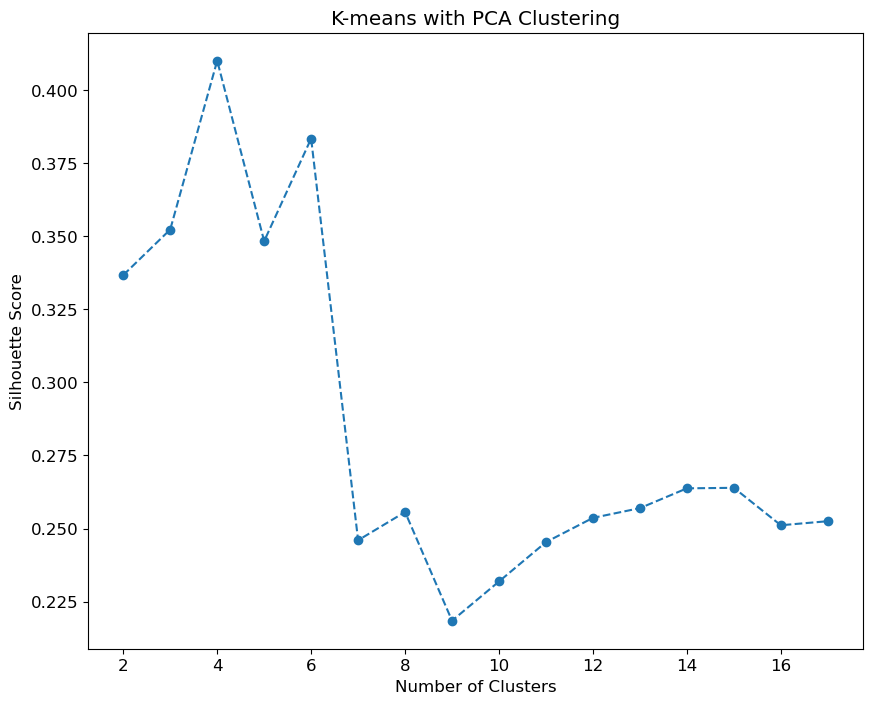

In [140]:
plt.figure(figsize= (10, 8))
plt.plot(range(2,18), silhouette_scores, marker = 'o', linestyle = '--')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('K-means with PCA Clustering')

### From the above analysis, inertia (sum of squares for each cluster, or density of clusters - the lower the better) sees a reduced improvement after n=5 though silhouette score plateaus (a measure of how far apart the clusters are - higher the better) gets worse. So we will got with 5 clusters from here on. Five clusters is also intuitively appropriate for our strategy as with too many clusters the strategy is unlikley to be invested enough to see compund returns across the top clusters.

So now we have chosen 4 principal components and 5 clusters. Below, we apply this pricess, ie we apply PCA and then cluster on the new PCA data, and then we produce a 3D chart to show the spread of the clusters across the 3 most important principal components.

In [141]:
def kmeans_pca(df):
    features = ['num_mentions', 'avg_sentiment_score', 'shill_score', '10_20_ema', '10_20_acc', '14d_RSI', '3d_change_CVD', 'AO', 'AC_CVD',
           'shill_score_7d_ema', 'avg_sentiment_score_7d_ema', 'num_mentions_7d_ema', 'BB_Width', 'P_vs_lower']

    #df_pca = df[:-14][features]
    df_pca = df[features]
    df_pca=df_pca.fillna(0)
    scaler = StandardScaler()
    segmentation_std = scaler.fit_transform(df_pca)

    from sklearn.decomposition import PCA
    pca = PCA()
    pca.fit(segmentation_std)
    pca.explained_variance_ratio_
    pca = PCA(n_components = 4, random_state=42)

    pca.fit(segmentation_std)
    pca.transform(segmentation_std)
    scores_pca = pca.transform(segmentation_std)

    kmeans_pca = KMeans(n_clusters = 5, random_state=42)
    kmeans_pca.fit(scores_pca)

    df_pca_kmeans = pd.concat([df_pca.reset_index(drop=True), pd.DataFrame(scores_pca)], axis = 1)
    df_pca_kmeans.columns.values[-4:] = ['PC1', 'PC2', 'PC3', 'PC4']
    df_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_
    df_pca_kmeans['Segment'] = df_pca_kmeans['Segment K-means PCA'].map({0: 'first', 1: 'second', 2: 'third', 3: 'fourth', 4: 'fifth'})

    x_axis = df_pca_kmeans['PC1']
    y_axis = df_pca_kmeans['PC2']
    z_axis = df_pca_kmeans['PC3']

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    colors = sns.color_palette('bright', n_colors=len(df_pca_kmeans['Segment'].unique()))
    for segment, color in zip(df_pca_kmeans['Segment'].unique(), colors):
        ix = df_pca_kmeans['Segment'] == segment
        ax.scatter(x_axis[ix], y_axis[ix], z_axis[ix], c=[color], label=segment, s=50)

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

    df_pca_kmeans = df_pca_kmeans.rename(columns = {'Segment K-means PCA': 'labels'} )

    df_pca_kmeans['date'] = df['date']
    df_pca_kmeans['price'] = df['price']

    return df_pca_kmeans, scores_pca, kmeans_pca.labels_

,num_mentions,avg_sentiment_score,shill_score,10_20_ema,10_20_acc,14d_RSI,3d_change_CVD,AO,AC_CVD,shill_score_7d_ema,...,BB_Width,P_vs_lower,PC1,PC2,PC3,PC4,labels,Segment,date,price
0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.00,0.0,0.000,0.0,...,0.0,0.0,2.202546,0.603506,-0.147446,-4.836766,1,second,2021-01-18,3.7868
1,0.0,0.0,0.0,0.996371,0.000000,0.000000,0.00,0.0,0.000,0.0,...,0.0,0.0,2.224199,0.590735,-0.158440,-4.821694,1,second,2021-01-19,3.6287
2,0.0,0.0,0.0,0.995759,0.000000,37.450927,0.00,0.0,0.000,0.0,...,0.0,0.0,1.242654,0.938494,0.236483,-4.803616,1,second,2021-01-20,3.7166
3,0.0,0.0,0.0,0.978252,0.000000,8.640458,-4352918.11,0.0,0.000,0.0,...,0.0,0.0,2.234598,0.525444,-0.005564,-4.984963,1,second,2021-01-21,2.9899
4,0.0,0.0,0.0,0.973584,0.984618,34.446003,6897304.31,0.0,3520611.106,0.0,...,0.0,0.0,-0.216590,1.404265,-1.038137,0.146303,0,first,2021-01-22,3.3352


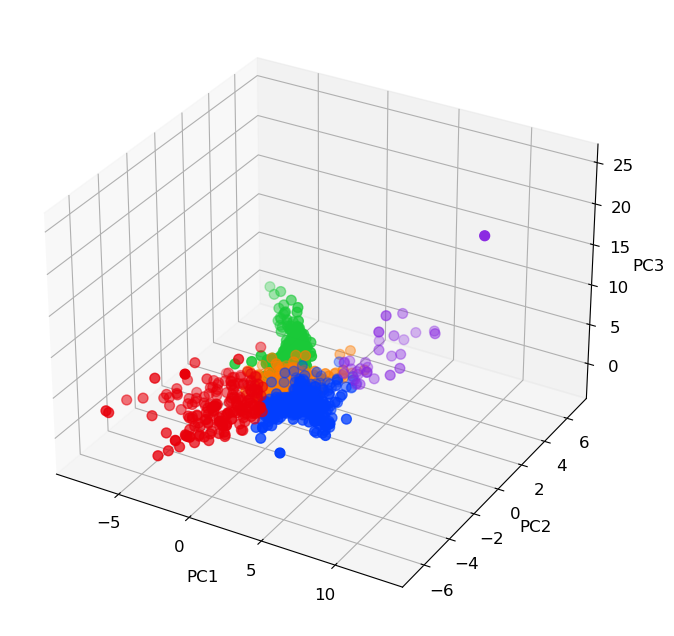

In [142]:
df_pca, scores_pca, kmeans_pca.labels_ = kmeans_pca(new_df)
df_pca.head()

#### Looking at silhouette scores to see if clustering has improved we can see it has actually worsened slightly, from 0.33 to 0.27

In [145]:
from sklearn.metrics import silhouette_score
silhouette_score(scores_pca, kmeans_pca.labels_)


0.27422130298328207

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


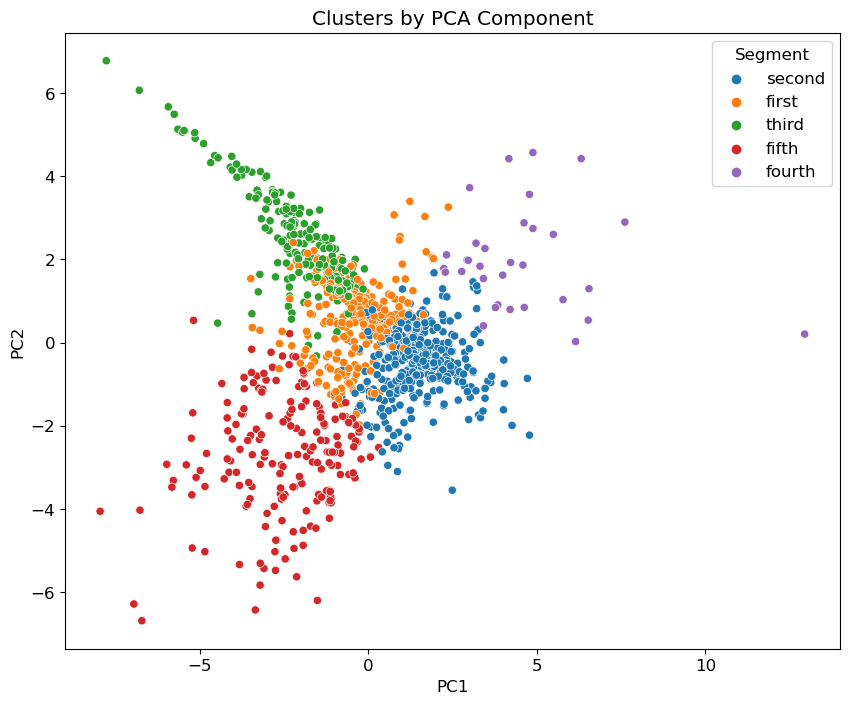

In [146]:
#Looking at the cluster distribution in 2D for greater clarity, across the 2 main PCs

x_axis = df_pca['PC1']
y_axis = df_pca['PC2']
plt.figure(figsize= (10,8))
sns.scatterplot(x_axis, y_axis, hue = df_pca['Segment']),
plt.title('Clusters by PCA Component')
plt.show()

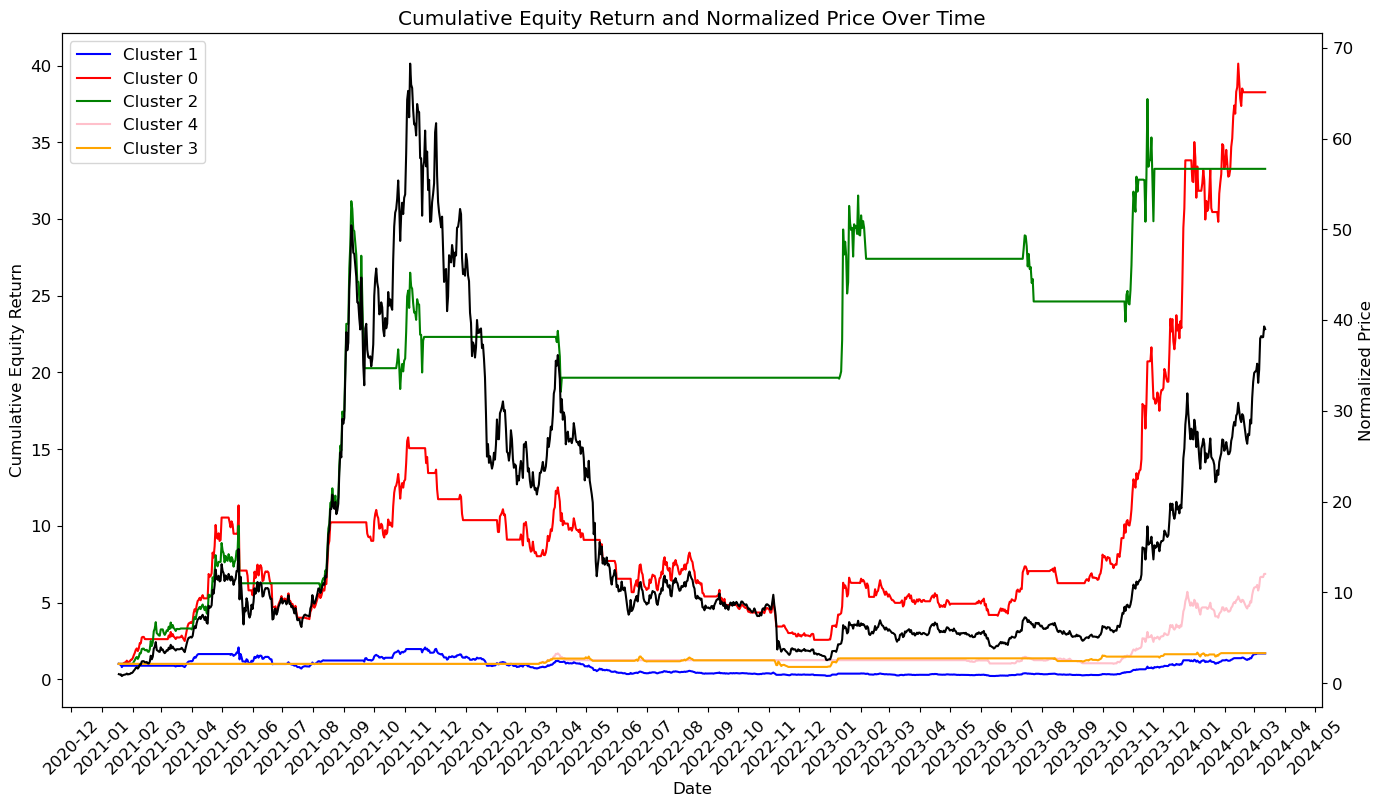

,Cluster,Count,Hit Rate,Mean,Std,Min,50%,Max
2,2.0,137.0,0.686131,0.227484,0.349453,-0.283466,0.158104,1.179882
3,4.0,134.0,0.567164,0.045093,0.136702,-0.186243,0.022983,0.444690
1,0.0,301.0,0.514950,0.088428,0.343127,-0.604878,0.008126,1.473469
0,1.0,455.0,0.468132,0.019208,0.210957,-0.545603,-0.014847,1.143383
4,3.0,29.0,0.413793,-0.033126,0.286017,-0.595953,-0.024276,0.697095


In [147]:
label_return_final(df_pca)

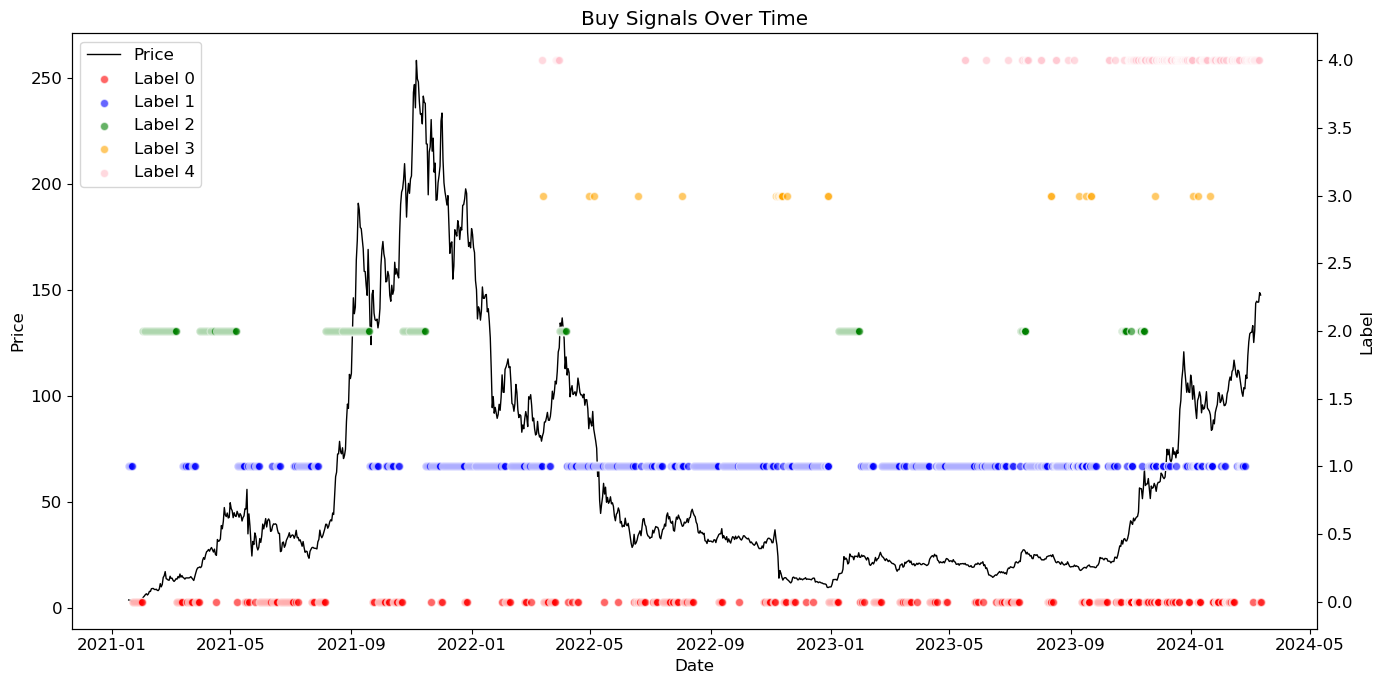

In [148]:
buy_signals_over_time(new_df, df_pca)

### But, the results of the top performing cluster are significantly better!

Initial results are quite promising, but to see a realistic backtest, we need to apply a multifold time based train test split. Here we use the train test function to go back and run a train/test on a rolling forward time frame. 

Given most of the coins have price history to late 2020, this generally means the test sert begins around mid-2021 in most cases, but in some cases this is later due to lack of history in the API. Given the late 2021 price moves, this can make a fairly material difference in the performance of the overall strategy.

In [149]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [150]:
df_pca

,num_mentions,avg_sentiment_score,shill_score,10_20_ema,10_20_acc,14d_RSI,3d_change_CVD,AO,AC_CVD,shill_score_7d_ema,...,stance,in_trade,trade_entry_price,in_trade_rtn,14d_rtn,14d_fwd_rtn,trade_rtn,equity_log_return,cumulative_equity_return,equity_curve
0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.00,0.000000,0.000000e+00,0.000000,...,0,False,None,0.0,0,0.0,0.789558,0.0,1.000000,1.000000
1,0.0,0.0,0.0,0.996371,0.000000,0.000000,0.00,0.000000,0.000000e+00,0.000000,...,0,False,None,0.0,0,0.0,0.823959,0.0,1.000000,1.000000
2,0.0,0.0,0.0,0.995759,0.000000,37.450927,0.00,0.000000,0.000000e+00,0.000000,...,0,False,None,0.0,0,0.0,0.804472,0.0,1.000000,1.000000
3,0.0,0.0,0.0,0.978252,0.000000,8.640458,-4352918.11,0.000000,0.000000e+00,0.000000,...,0,False,None,0.0,0,0.0,1.115489,0.0,1.000000,1.000000
4,0.0,0.0,0.0,0.973584,0.984618,34.446003,6897304.31,0.000000,3.520611e+06,0.000000,...,0,False,None,0.0,0,0.0,2.009025,0.0,1.000000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403,0.0,0.0,0.0,1.037022,1.010055,80.033865,28631338.43,14.387824,1.688183e+07,11.385391,...,0,False,None,0.0,0,0.0,NaN,0.0,1.700853,1.700853
1404,0.0,0.0,0.0,1.040689,1.010320,78.802719,15362844.14,17.125588,8.206060e+06,8.539043,...,0,False,None,0.0,0,0.0,NaN,0.0,1.700853,1.700853
1405,0.0,0.0,0.0,1.042630,1.007888,78.872718,8899388.09,19.783941,6.808783e+06,6.404283,...,0,False,None,0.0,0,0.0,NaN,0.0,1.700853,1.700853
1406,0.0,0.0,0.0,1.045990,1.006372,81.753792,8546026.79,22.103706,9.033017e+06,4.803212,...,0,False,None,0.0,0,0.0,NaN,0.0,1.700853,1.700853


In [151]:
df_pca.columns

Index(['num_mentions', 'avg_sentiment_score', 'shill_score', '10_20_ema',
       '10_20_acc', '14d_RSI', '3d_change_CVD', 'AO', 'AC_CVD',
       'shill_score_7d_ema', 'avg_sentiment_score_7d_ema',
       'num_mentions_7d_ema', 'BB_Width', 'P_vs_lower', 'PC1', 'PC2', 'PC3',
       'PC4', 'labels', 'Segment', 'date', 'price', 'log_price', 'log_rtn',
       'trigger', 'stance', 'in_trade', 'trade_entry_price', 'in_trade_rtn',
       '14d_rtn', '14d_fwd_rtn', 'trade_rtn', 'equity_log_return',
       'cumulative_equity_return', 'equity_curve'],
      dtype='object')

In [152]:
new_df.columns

Index(['date', 'price', '24h_volume', 'coin_mentions', 'num_mentions',
       'avg_sentiment_score', 'shill_score', '20d_ema', '10d_ema', '5d_ema',
       '10_20_ema', '5_10_ema', '10_20_acc', '5_10_acc', '14d_RSI', '7d_RSI',
       'CVD', '3d_change_CVD', 'z_score_3d_change_CVD', '5d_sma_CVD', 'AC_CVD',
       'AO', 'AC', 'z_score_3d_change_shill', 'log_shill_score',
       '5d_sma_shill', '34d_sma_shill', 'AO_shill', '20d_SMA', '20d_STD',
       'Upper_Band', 'Lower_Band', 'BB_Width', 'P_vs_upper', 'P_vs_lower',
       '14d_rtn', '7d_rtn', 'shill_score_7d_ema', 'avg_sentiment_score_7d_ema',
       'num_mentions_7d_ema'],
      dtype='object')

In [153]:
df_pca_rtn = df_pca.copy()
df_pca_rtn['14d_fwd_rtn'] = new_df['14d_rtn']
df_pca_rtn['14d_fwd_rtn'] = df_pca_rtn['14d_fwd_rtn'].fillna(0)
df_pca_rtn['date'] = new_df['date']
df_pca_rtn['price'] = new_df['price']

In [154]:
df_pca_rtn['date'].tail(15)

1393   2024-03-03
1394   2024-03-04
1395   2024-03-04
1396   2024-03-05
1397   2024-03-05
1398   2024-03-05
1399   2024-03-05
1400   2024-03-05
1401   2024-03-06
1402   2024-03-07
1403   2024-03-08
1404   2024-03-09
1405   2024-03-10
1406   2024-03-11
1407   2024-03-12
Name: date, dtype: datetime64[ns]

In [155]:
df_pca_rtn.tail(20)

,num_mentions,avg_sentiment_score,shill_score,10_20_ema,10_20_acc,14d_RSI,3d_change_CVD,AO,AC_CVD,shill_score_7d_ema,...,stance,in_trade,trade_entry_price,in_trade_rtn,14d_rtn,14d_fwd_rtn,trade_rtn,equity_log_return,cumulative_equity_return,equity_curve
1388,1.0,0.381107,0.381107,1.042806,1.010158,78.627082,8376631.09,14.867647,6.701305e+06,10.116623,...,0,False,None,0.0,0,0.111180,1.111180,0.0,1.700853,1.700853
1389,1.0,8.817323,8.817323,1.045417,1.007448,78.627082,8376631.09,15.251176,5.025979e+06,9.791798,...,0,False,None,0.0,0,0.118674,1.118674,0.0,1.700853,1.700853
1390,4.0,3.355824,13.423297,1.046441,1.004858,78.627082,8376631.09,15.634706,3.350652e+06,10.699673,...,0,False,None,0.0,0,0.114811,1.114811,0.0,1.700853,1.700853
1391,1.0,2.929677,2.929677,1.046715,1.002712,79.131662,4693251.94,16.118882,5.429928e+06,8.757174,...,0,False,None,0.0,0,0.110521,1.110521,0.0,1.700853,1.700853
1392,1.0,1.357161,1.357161,1.046036,1.000529,79.131662,4693251.94,16.603059,2.815951e+06,6.907171,...,0,False,None,0.0,0,0.144670,1.144670,0.0,1.700853,1.700853
1393,1.0,2.391796,2.391796,1.044780,0.998950,79.266368,9921622.80,16.259059,6.059997e+06,5.778327,...,0,False,None,0.0,0,0.134834,NaN,0.0,1.700853,1.700853
1394,2.0,-2.280864,-4.561729,1.045137,0.999345,82.039851,13282055.65,16.445588,1.051862e+07,3.193313,...,0,False,None,0.0,0,0.000000,NaN,0.0,1.700853,1.700853
1395,2.0,3.811813,7.623626,1.044551,0.999146,82.039851,13282055.65,16.538882,6.923559e+06,4.300891,...,0,False,None,0.0,0,0.000000,NaN,0.0,1.700853,1.700853
1396,2.0,3.443870,6.887741,1.027802,0.990575,58.722594,-17035242.52,12.238706,-6.814097e+06,5.089418,...,0,False,None,0.0,0,0.000000,NaN,0.0,1.700853,1.700853
1397,2.0,3.443870,6.887741,1.032448,0.991806,58.722594,-17035242.52,13.690765,-8.610409e+06,4.489977,...,0,False,None,0.0,0,0.000000,NaN,0.0,1.700853,1.700853


In [211]:
def dynamic_label_return_strategy(df):
    tscv = TimeSeriesSplit(n_splits=20)
    overall_returns = []
    equity_curves = []
    top_clusters = []
    test_data_parts = []
    trade_dates = []    
    
    features = ['PC1', 'PC2', 'PC3', 'PC4']
    features_price = ['date', 'PC1', 'PC2', 'PC3', 'PC4', 'price', '14d_fwd_rtn']
    df = df[features_price]
    
    df['log_price'] = np.log(df['price'])
    df['log_rtn'] = df['log_price'].diff()
    df.dropna(inplace=True)
    

    
    summary_df = pd.DataFrame(columns=['Cluster', 'Count', 'Hit Rate', 'Mean', 'Std', 'Min', '50%', 'Max'])

    # Parameters for the strategy
    holding_period = 28
    stop_loss = 0.10  # 10%
    
    
    for fold, (train_index, test_index) in enumerate(tscv.split(df)):
        train_data, test_data = df.iloc[train_index].copy(), df.iloc[test_index].copy()
        kmeans = KMeans(n_clusters=5, random_state=42).fit(train_data[['PC1', 'PC2', 'PC3', 'PC4']])
        train_labels = kmeans.predict(train_data[['PC1', 'PC2', 'PC3', 'PC4']])
        test_labels = kmeans.predict(test_data[['PC1', 'PC2', 'PC3', 'PC4']])
        test_data['predicted_label'] = test_labels
        test_data_parts.append(test_data)
        

        # Determine the top-performing cluster
        train_data['label'] = train_labels
        top_cluster = train_data.groupby('label')['14d_fwd_rtn'].mean().idxmax()
        top_clusters.append(top_cluster)

        test_data['is_top_cluster'] = test_data['predicted_label'] == top_cluster

        test_data['in_trade'] = False
        test_data['trade_entry_price'] = np.nan
        test_data['exit_price'] = np.nan
        test_data['trade_return'] = np.nan
        test_data['entry'] = np.nan 

        in_trade = False
        entry_index = None    

        for i in range(len(test_data)):
            if test_data.iloc[i]['is_top_cluster'] and not in_trade:
                in_trade = True
                #test_data['entry'] == 1
                test_data.iloc[i, test_data.columns.get_loc('entry')] = 1
                entry_index = i
                entry_date = test_data.iloc[i]['date']
                trade_dates.append(entry_date)

            if in_trade and i >= entry_index:
                if entry_index == i:  # Set entry price at open of trade
                    test_data.iloc[i, test_data.columns.get_loc('trade_entry_price')] = test_data.iloc[i]['price']
                    entry_price = test_data.iloc[i]['price']

                current_price = test_data.iloc[i]['price']
                current_return = (current_price - entry_price) / entry_price

                if current_return < -stop_loss or (i - entry_index) >= holding_period:
                    test_data.iloc[i, test_data.columns.get_loc('exit_price')] = current_price
                    test_data.iloc[i, test_data.columns.get_loc('trade_return')] = current_return
                    overall_returns.append(current_return)
                    in_trade = False 

        if in_trade:  
            current_price = test_data.iloc[-1]['price']
            current_return = (current_price - entry_price) / entry_price
            test_data.iloc[-1, test_data.columns.get_loc('exit_price')] = current_price
            test_data.iloc[-1, test_data.columns.get_loc('trade_return')] = current_return
            overall_returns.append(current_return)
        

    
    full_test_data = pd.concat(test_data_parts)
    full_test_data.reset_index(drop=True, inplace=True)
    
    
    #Now building strategy
    
    
    full_test_data['trigger'] = np.where(full_test_data['is_top_cluster'] == True, 1, 0)
    full_test_data['stance'] = 0
    full_test_data['in_trade'] = False
    full_test_data['trade_entry_price'] = None
    full_test_data['in_trade_rtn'] = 0
    full_test_data['14d_rtn'] = 0
    full_test_data['14d_fwd'] = 0
    

    for i in range(len(full_test_data) - holding_period -1):
        if full_test_data.loc[i, 'trigger'] == 1 and not full_test_data.loc[i, 'in_trade']:
            full_test_data.loc[i+1, 'in_trade'] = True
            full_test_data.loc[i + 1, 'stance'] = 1
            full_test_data.loc[i, 'trade_entry_price'] = full_test_data.loc[i, 'price']

            full_test_data.loc[i+holding_period, '14d_fwd'] = (full_test_data.loc[i+holding_period, 'price'] / full_test_data.loc[i, 'price'])-1

            for j in range(i + 1, i + holding_period + 1):
                full_test_data.loc[j, 'stance'] = 1
                full_test_data.loc[j, 'in_trade'] = True
                full_test_data.loc[j, 'trade_entry_price'] = full_test_data.loc[i, 'trade_entry_price']

                full_test_data.loc[j, 'in_trade_rtn'] = (full_test_data.loc[j, 'price'] / full_test_data.loc[i, 'trade_entry_price']) - 1
                if full_test_data.loc[j, 'in_trade_rtn'] < -stop_loss or (j - i) == holding_period:
                    full_test_data.loc[j + 1, 'trigger'] = -1
                    full_test_data.loc[j + 1, 'stance'] = 0
                    full_test_data.loc[j + 1, 'in_trade'] = False

                    full_test_data.loc[i, 'trade_rtn'] = full_test_data.loc[j, 'price'] / full_test_data.loc[i, 'price']
                    break  # Exit the trade loop upon stop loss trigger or end of holding period

    if full_test_data.loc[i, 'trigger'] == 1 and full_test_data.loc[i, 'in_trade']:
        full_test_data.loc[i+1, 'in_trade'] = True
        full_test_data.loc[i + 1, 'stance'] = 1
        full_test_data.loc[i, 'trade_entry_price'] = full_test_data.loc[i-1, 'trade_entry_price']
        full_test_data.loc[i+holding_period, '14d_fwd_rtn'] = (full_test_data.loc[i+holding_period, 'price'] / full_test_data.loc[i, 'price'])-1

        for j in range(i + 1, i + holding_period + 1):
            full_test_data.loc[j, 'stance'] = 1
            full_test_data.loc[j, 'in_trade'] = True
            full_test_data.loc[j, 'trade_entry_price'] = full_test_data.loc[i, 'trade_entry_price']

            full_test_data.loc[j, 'in_trade_rtn'] = (full_test_data.loc[j, 'price'] / full_test_data.loc[i, 'trade_entry_price']) - 1
            if full_test_data.loc[j, 'in_trade_rtn'] < -stop_loss or (j - i) == holding_period:
                full_test_data.loc[j + 1, 'trigger'] = -1
                full_test_data.loc[j + 1, 'stance'] = 0
                full_test_data.loc[j + 1, 'in_trade'] = False

                full_test_data.loc[i, 'trade_rtn'] = full_test_data.loc[j, 'price'] / full_test_data.loc[i, 'price']

                break  # Exit the trade loop upon stop loss trigger or end of holding period

    # Calculate equity log return
    full_test_data['equity_log_return'] = np.where(full_test_data['stance'] == 1, full_test_data['log_rtn'], 0)
    full_test_data['cumulative_equity_return'] = full_test_data['equity_log_return'].cumsum().apply(np.exp)
    
    final_return = full_test_data['cumulative_equity_return'].iloc[-1] -1
    
    hit_rate = len(list(filter(lambda overall_returns: overall_returns > 0, overall_returns))) / len(overall_returns)

    average_return = statistics.mean(overall_returns) if overall_returns else 0 
    
    results_df = pd.DataFrame({
    'Trade Date': trade_dates,
    'Return': overall_returns
})
    summary_stats = pd.DataFrame({
    'Metric': ['Final Cumulative Return', 'Average Return', 'Hit Rate'],
    'Value': [f"{final_return * 100:.2f}%", f"{average_return}", f"{hit_rate}"]
})
    
    print("Trade Results:")
    print(results_df)
    print("\nSummary Statistics:")
    print(summary_stats)
    
    return full_test_data, results_df, summary_stats

In [212]:
def dynamic_label_return_strategy_plot(df):
    #plt.style.use('dark_background')
    fig = plt.figure(figsize=(14, 8))
    plt.plot(df['date'], df['cumulative_equity_return'], label='Equity Curve', color='#77dd77')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Equity Return')
    plt.title('Equity Curve Over Time')
    plt.legend()
    plt.show()


#### Finally, let's run the above strategy for 20 or so of the major, most high profile coins over the last couple of years. We'll do it in batches otherwise the API breaks.

In [217]:
def kmeans_pca_basic(df):
    features = ['num_mentions', 'avg_sentiment_score', 'shill_score', '10_20_ema', '10_20_acc', '14d_RSI', '3d_change_CVD', 'AO', 'AC_CVD',
           'shill_score_7d_ema', 'avg_sentiment_score_7d_ema', 'num_mentions_7d_ema', 'BB_Width', 'P_vs_lower']

    #df_pca = df[:-14][features]
    df_pca = df[features]
    df_pca=df_pca.fillna(0)
    scaler = StandardScaler()
    segmentation_std = scaler.fit_transform(df_pca)

    from sklearn.decomposition import PCA
    #pca = PCA()
    pca = PCA(n_components = 4, random_state=42)

    pca.fit(segmentation_std)
    pca.transform(segmentation_std)
    scores_pca = pca.transform(segmentation_std)

    kmeans_pca = KMeans(n_clusters = 5, random_state=42)
    kmeans_pca.fit(scores_pca)

    df_pca_kmeans = pd.concat([df_pca.reset_index(drop=True), pd.DataFrame(scores_pca)], axis = 1)
    df_pca_kmeans.columns.values[-4:] = ['PC1', 'PC2', 'PC3', 'PC4']
    df_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_
    df_pca_kmeans['Segment'] = df_pca_kmeans['Segment K-means PCA'].map({0: 'first', 1: 'second', 2: 'third', 3: 'fourth', 4: 'fifth'})

    df_pca_kmeans = df_pca_kmeans.rename(columns = {'Segment K-means PCA': 'labels'} )

    df_pca_kmeans['14d_rtn'] = df['14d_rtn']
    df_pca_kmeans['14d_fwd_rtn'] = df['14d_rtn']
    df_pca_kmeans['14d_rtn'] = df_pca_kmeans['14d_rtn'].fillna(0)
    df_pca_kmeans['14d_fwd_rtn'] = df_pca_kmeans['14d_fwd_rtn'].fillna(0)

    df_pca_kmeans['date'] = df['date']
    df_pca_kmeans['price'] = df['price']

    return df_pca_kmeans



In [218]:
community_tickers = ['eth', 'btc', 'sol', 'avax', 'ldo']
coins_list_degen = coins_list[coins_list['Ticker'].isin(community_tickers)]

df1 = pd.DataFrame(columns = ['coin', 'TR', 'Avg', 'hit_rate'])

for coin in coins_list_degen['Ticker'].str.upper():
    
    print(coin)
    try:
        new_df = coin_df(1150, coin)
        df_pca = kmeans_pca_basic(new_df)
        df_pca_rtn = df_pca.copy()
        df_pca_rtn['14d_fwd_rtn'] = new_df['14d_rtn']
        df_pca_rtn['14d_fwd_rtn'] = df_pca_rtn['14d_fwd_rtn'].fillna(0)
        df_pca_rtn['date'] = new_df['date']
        df_pca_rtn['price'] = new_df['price']
        full_test_data, results_df, summary_stats = dynamic_label_return_strategy(df_pca_rtn)


        TR = round(float(summary_stats.iloc[0,1].replace('%', '')) / 100, 2)
        avg = round(float(summary_stats.iloc[1,1]),2)
        hit_rate = round(float(summary_stats.iloc[2,1]),2)

        df1 = df1.append({'coin': coin, 'TR': TR, 'Avg': avg, 'hit_rate': hit_rate}, ignore_index=True)

    except:
        None
df1

BTC


divide by zero encountered in log
invalid value encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trade Results:
   Trade Date    Return
0  2021-05-24 -0.108029
1  2021-05-31 -0.103963
2  2021-06-24 -0.080290
3  2021-07-26  0.329002
4  2021-10-05  0.000000
5  2022-09-12 -0.120284
6  2022-11-05 -0.129212
7  2023-01-13  0.142123
8  2023-03-13  0.162359
9  2023-04-13 -0.102424
10 2023-06-22  0.000000
11 2023-06-22  0.017623
12 2023-07-13 -0.070748
13 2023-10-01  0.018155
14 2023-10-17  0.000000
15 2023-10-20  0.177712
16 2023-12-02  0.045704
17 2024-01-08 -0.111152
18 2024-02-11  0.072364
19 2024-02-18  0.093976
20 2024-02-29  0.042418
21 2024-03-10  0.032199

Summary Statistics:
                    Metric                 Value
0  Final Cumulative Return                54.06%
1           Average Return  0.013978780145560013
2                 Hit Rate                   0.5
ETH


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
divide by zero encountered in log
invalid value encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trade Results:
   Trade Date    Return
0  2021-05-21 -0.137636
1  2021-09-21  0.401725
2  2021-11-16 -0.101628
3  2022-03-18  0.000000
4  2022-03-23  0.073310
5  2022-06-24 -0.101884
6  2022-07-07 -0.114013
7  2022-07-14  0.136105
8  2022-07-25  0.173384
9  2022-08-15 -0.152733
10 2022-08-20 -0.013921
11 2022-09-09 -0.142868
12 2022-10-26  0.034129
13 2022-11-08 -0.173843
14 2022-11-09  0.035802
15 2022-11-21  0.120261
16 2022-12-16  0.045559
17 2023-01-09  0.220806
18 2023-02-03  0.006853
19 2023-03-13  0.060014
20 2023-09-30 -0.054318
21 2023-10-23  0.024685
22 2023-11-09 -0.075213
23 2023-12-05 -0.014464
24 2024-01-10 -0.002395
25 2024-02-14  0.086492
26 2024-02-28  0.050412
27 2024-03-06  0.039033

Summary Statistics:
                    Metric                 Value
0  Final Cumulative Return                21.28%
1           Average Return  0.015130516349546192
2                 Hit Rate    0.5357142857142857
SOL


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
divide by zero encountered in log
invalid value encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trade Results:
   Trade Date    Return
0  2021-03-28  1.624208
1  2021-05-16 -0.253191
2  2021-08-11  3.589510
3  2021-10-01 -0.103924
4  2021-10-21  0.023675
5  2023-01-09  0.394462
6  2023-07-13  0.055748
7  2023-07-16 -0.105762
8  2023-10-21  0.403479
9  2023-11-10  0.002470
10 2023-11-15 -0.116613
11 2023-11-17 -0.117245
12 2023-12-07  0.037053
13 2024-03-04  0.122308

Summary Statistics:
                    Metric                Value
0  Final Cumulative Return             1518.91%
1           Average Return  0.39686978025617636
2                 Hit Rate   0.6428571428571429
AVAX


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
divide by zero encountered in log
invalid value encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trade Results:
   Trade Date    Return
0  2021-03-18 -0.121735
1  2021-03-30 -0.115476
2  2021-04-27  0.254964
3  2021-05-15 -0.330643
4  2021-05-25 -0.139823
5  2021-05-31 -0.143550
6  2021-06-13 -0.241244
7  2021-06-27  0.147244
8  2021-08-05  2.439352
9  2021-09-03  0.027457
10 2021-09-05 -0.212253
11 2021-09-10  0.227383
12 2021-10-21  0.049122
13 2021-11-01  0.854151
14 2021-11-30 -0.104892
15 2021-12-03 -0.140971
16 2021-12-17  0.027434
17 2022-02-09 -0.134814
18 2022-02-15 -0.100032
19 2022-03-19 -0.055624
20 2022-06-24 -0.114802
21 2022-07-06 -0.126239
22 2022-07-14  0.183704
23 2022-07-28 -0.050000
24 2022-09-09 -0.106477
25 2022-10-23 -0.208461
26 2022-12-13 -0.139535
27 2023-01-04  0.000828
28 2023-01-10  0.636292
29 2023-02-08 -0.109896
30 2023-02-15 -0.100301
31 2023-03-14  0.057726
32 2023-04-12 -0.077766
33 2023-06-25  0.032738
34 2023-10-04  0.024752
35 2023-10-21  1.283489
36 2023-11-21  0.149842
37 2023-12-02  0.906025
38 2023-12-29 -0.138626
39 2024-01-11 -0.101807
4

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
divide by zero encountered in log
invalid value encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trade Results:
  Trade Date    Return
0 2022-07-03  1.867589
1 2022-08-16 -0.130148
2 2022-08-22 -0.206581
3 2023-01-10  0.175311
4 2023-03-03 -0.081560
5 2023-05-29  0.042182
6 2023-10-10 -0.010383
7 2023-12-27  0.286775
8 2024-01-10 -0.115303
9 2024-02-13  0.057345

Summary Statistics:
                    Metric               Value
0  Final Cumulative Return             103.01%
1           Average Return  0.1885227523115458
2                 Hit Rate                 0.5


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,coin,TR,Avg,hit_rate
0,BTC,0.54,0.01,0.50
1,ETH,0.21,0.02,0.54
2,SOL,15.19,0.40,0.64
3,AVAX,2.08,0.11,0.45
4,LDO,1.03,0.19,0.50


In [219]:
community_tickers = ['doge', 'shib', 'rndr', 'aave', 'snx']
coins_list_degen = coins_list[coins_list['Ticker'].isin(community_tickers)]



#new_df = coin_df(1150, coin)
#df_pca = kmeans_pca(new_df)
#df_pca_rtn = df_pca.copy()
#df_pca_rtn['14d_fwd_rtn'] = new_df['14d_rtn']
#df_pca_rtn['14d_fwd_rtn'] = df_pca_rtn['14d_fwd_rtn'].fillna(0)
#df_pca_rtn['date'] = new_df['date']
#df_pca_rtn['price'] = new_df['price']
#full_test_data, results_df, summary_stats = dynamic_label_return_strategy(df_pca_rtn)


df2 = pd.DataFrame(columns = ['coin', 'TR', 'Avg', 'hit_rate'])

for coin in coins_list_degen['Ticker'].str.upper():
    
    print(coin)
    try:
        new_df = coin_df(1150, coin)
        df_pca = kmeans_pca_basic(new_df)
        df_pca_rtn = df_pca.copy()
        df_pca_rtn['14d_fwd_rtn'] = new_df['14d_rtn']
        df_pca_rtn['14d_fwd_rtn'] = df_pca_rtn['14d_fwd_rtn'].fillna(0)
        df_pca_rtn['date'] = new_df['date']
        df_pca_rtn['price'] = new_df['price']
        full_test_data, results_df, summary_stats = dynamic_label_return_strategy(df_pca_rtn)


        TR = round(float(summary_stats.iloc[0,1].replace('%', '')) / 100, 2)
        avg = round(float(summary_stats.iloc[1,1]),2)
        hit_rate = round(float(summary_stats.iloc[2,1]),2)

        df2 = df2.append({'coin': coin, 'TR': TR, 'Avg': avg, 'hit_rate': hit_rate}, ignore_index=True)
        #df = df.append({'coin': coin, 'corr_shill': correl_value}, ignore_index=True)
    except:
        None
df2

DOGE


divide by zero encountered in log
invalid value encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trade Results:
  Trade Date    Return
0 2021-05-21 -0.143803
1 2021-05-24 -0.149389
2 2021-05-29 -0.409742
3 2021-06-22 -0.028209
4 2021-07-16  0.666492
5 2021-08-24 -0.115854
6 2021-09-08 -0.016362
7 2022-01-13 -0.173559
8 2022-02-04 -0.132612

Summary Statistics:
                    Metric                 Value
0  Final Cumulative Return               -71.35%
1           Average Return  -0.05589299816862143
2                 Hit Rate    0.1111111111111111
SHIB


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
divide by zero encountered in log
invalid value encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trade Results:
  Trade Date    Return
0 2021-07-08 -0.113466
1 2021-07-14 -0.145028
2 2021-07-20  0.366723
3 2021-08-24 -0.068182
4 2021-08-27 -0.107095
5 2021-08-31 -0.118076
6 2021-09-11  2.943870
7 2021-10-16  1.010113
8 2024-03-01  0.877297

Summary Statistics:
                    Metric               Value
0  Final Cumulative Return             479.29%
1           Average Return  0.5162396025259389
2                 Hit Rate  0.4444444444444444
RNDR


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
divide by zero encountered in log
invalid value encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trade Results:
   Trade Date    Return
0  2022-01-29 -0.157911
1  2022-05-19 -0.196970
2  2022-06-19  0.016279
3  2022-06-22  0.138211
4  2022-11-02 -0.219196
5  2022-11-29 -0.113924
6  2022-12-20 -0.048724
7  2023-01-08  3.016055
8  2023-02-16  0.000000
9  2023-03-14 -0.121475
10 2023-04-12  0.334379
11 2023-05-17 -0.175858
12 2023-10-29 -0.121129
13 2023-11-16  0.000000
14 2023-11-17  0.429040
15 2024-02-20  0.761824

Summary Statistics:
                    Metric                Value
0  Final Cumulative Return              -28.07%
1           Average Return  0.22128759323396507
2                 Hit Rate                0.375
AAVE


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
divide by zero encountered in log
invalid value encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trade Results:
   Trade Date    Return
0  2021-04-18 -0.168197
1  2021-05-15 -0.199907
2  2021-05-21 -0.102923
3  2021-05-23 -0.132011
4  2021-07-26  0.350230
5  2021-09-08 -0.116793
6  2021-09-21  0.116673
7  2021-10-22  0.072856
8  2021-12-23  0.078979
9  2022-03-02 -0.152505
10 2022-03-13  0.597234
11 2022-04-11  0.001267
12 2022-07-08  0.435754
13 2022-11-15  0.077049
14 2023-01-14  0.110672
15 2023-03-11  0.182635
16 2023-06-13  0.303811
17 2023-07-31 -0.036408
18 2023-08-04  0.032243
19 2024-02-02  0.216166
20 2024-03-07 -0.003584

Summary Statistics:
                    Metric                Value
0  Final Cumulative Return              117.56%
1           Average Return  0.07920196119525269
2                 Hit Rate   0.6190476190476191
SNX


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
divide by zero encountered in log
invalid value encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trade Results:
   Trade Date    Return
0  2021-04-18 -0.112857
1  2021-05-12  0.138205
2  2021-05-23 -0.114291
3  2021-06-09 -0.206409
4  2021-06-12 -0.226774
5  2021-06-22  0.958852
6  2021-07-20  0.490859
7  2021-09-10 -0.118739
8  2021-09-29 -0.001939
9  2021-12-05 -0.162541
10 2021-12-14  0.199369
11 2022-05-06 -0.294604
12 2022-06-14 -0.163705
13 2022-06-19  0.339704
14 2022-11-16 -0.040067
15 2022-11-18 -0.119224

Summary Statistics:
                    Metric                Value
0  Final Cumulative Return              -79.79%
1           Average Return  0.03536500295655744
2                 Hit Rate               0.3125


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,coin,TR,Avg,hit_rate
0,DOGE,-0.71,-0.06,0.11
1,SHIB,4.79,0.52,0.44
2,RNDR,-0.28,0.22,0.38
3,AAVE,1.18,0.08,0.62
4,SNX,-0.80,0.04,0.31


In [220]:
community_tickers = ['dydx', 'op', 'arb', 'matic', 'beam']
coins_list_degen = coins_list[coins_list['Ticker'].isin(community_tickers)]

 

#new_df = coin_df(1150, coin)
#df_pca = kmeans_pca(new_df)
#df_pca_rtn = df_pca.copy()
#df_pca_rtn['14d_fwd_rtn'] = new_df['14d_rtn']
#df_pca_rtn['14d_fwd_rtn'] = df_pca_rtn['14d_fwd_rtn'].fillna(0)
#df_pca_rtn['date'] = new_df['date']
#df_pca_rtn['price'] = new_df['price']
#full_test_data, results_df, summary_stats = dynamic_label_return_strategy(df_pca_rtn)


df3 = pd.DataFrame(columns = ['coin', 'TR', 'Avg', 'hit_rate'])

for coin in coins_list_degen['Ticker'].str.upper():
    
    print(coin)
    try:
        new_df = coin_df(1150, coin)
        df_pca = kmeans_pca_basic(new_df)
        df_pca_rtn = df_pca.copy()
        df_pca_rtn['14d_fwd_rtn'] = new_df['14d_rtn']
        df_pca_rtn['14d_fwd_rtn'] = df_pca_rtn['14d_fwd_rtn'].fillna(0)
        df_pca_rtn['date'] = new_df['date']
        df_pca_rtn['price'] = new_df['price']
        full_test_data, results_df, summary_stats = dynamic_label_return_strategy(df_pca_rtn)


        TR = round(float(summary_stats.iloc[0,1].replace('%', '')) / 100, 2)
        avg = round(float(summary_stats.iloc[1,1]),2)
        hit_rate = round(float(summary_stats.iloc[2,1]),2)

        df3 = df3.append({'coin': coin, 'TR': TR, 'Avg': avg, 'hit_rate': hit_rate}, ignore_index=True)
        #df = df.append({'coin': coin, 'corr_shill': correl_value}, ignore_index=True)
    except:
        None
df3

MATIC


divide by zero encountered in log
invalid value encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trade Results:
  Trade Date    Return
0 2021-03-29 -0.122244
1 2021-04-08  1.138972
2 2021-05-28 -0.103076
3 2021-12-07 -0.110495
4 2021-12-26 -0.133519
5 2022-07-19 -0.101243
6 2022-07-21 -0.149498

Summary Statistics:
                    Metric                 Value
0  Final Cumulative Return                98.56%
1           Average Return  0.059842587507997626
2                 Hit Rate   0.14285714285714285
OP


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
divide by zero encountered in log
invalid value encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trade Results:
   Trade Date    Return
0  2022-07-12  3.217778
1  2022-08-09 -0.045820
2  2022-10-26 -0.132735
3  2023-01-12  0.725899
4  2023-03-14 -0.112915
5  2023-07-19  0.095208
6  2023-11-09 -0.028129
7  2023-11-12 -0.126304
8  2023-12-11  0.740838
9  2024-01-02  0.000808
10 2024-02-23  0.242873

Summary Statistics:
                    Metric               Value
0  Final Cumulative Return             789.09%
1           Average Return  0.4161364051945151
2                 Hit Rate  0.5454545454545454
ARB


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
divide by zero encountered in log
invalid value encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trade Results:
   Trade Date    Return
0  2023-04-19 -0.100954
1  2023-04-25 -0.101566
2  2023-05-07  0.000000
3  2023-05-08  0.120694
4  2023-05-30 -0.184632
5  2023-06-10  0.001108
6  2023-06-19  0.111188
7  2023-07-11  0.109918
8  2023-07-24 -0.041224
9  2023-08-07 -0.132217
10 2023-09-23  0.134641
11 2023-10-10 -0.024535
12 2023-10-16  0.177856
13 2023-11-13 -0.147995
14 2023-11-21  0.000000
15 2023-12-11  0.340212
16 2024-01-18 -0.107305
17 2024-01-30 -0.079257
18 2024-02-12 -0.010549
19 2024-02-20 -0.100408
20 2024-02-23  0.122477

Summary Statistics:
                    Metric                  Value
0  Final Cumulative Return                 55.30%
1           Average Return  0.0041644103716102065
2                 Hit Rate    0.38095238095238093
DYDX


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
divide by zero encountered in log
invalid value encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trade Results:
   Trade Date    Return
0  2022-10-12  0.046897
1  2022-10-26 -0.121846
2  2022-11-09  0.218962
3  2022-12-08  0.000000
4  2022-12-14 -0.128109
5  2023-01-11  0.179562
6  2023-02-06 -0.132368
7  2023-02-10 -0.003273
8  2023-03-16  0.101844
9  2023-04-14  0.155311
10 2023-04-20 -0.105869
11 2023-04-24 -0.143949
12 2023-05-20 -0.055607
13 2023-07-14  0.033365
14 2023-08-12 -0.103634
15 2023-08-31 -0.105596
16 2023-10-01  0.179462
17 2023-10-26  0.047373
18 2023-11-14 -0.135025
19 2023-11-18 -0.104547
20 2023-12-07  0.031506
21 2024-01-30  0.227680
22 2024-02-27  0.158278

Summary Statistics:
                    Metric                 Value
0  Final Cumulative Return                49.85%
1           Average Return  0.010452859286117383
2                 Hit Rate    0.4782608695652174
BEAM


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
divide by zero encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trade Results:
   Trade Date    Return
0  2021-04-23 -0.140880
1  2021-04-25  0.371725
2  2021-07-10  0.005837
3  2021-07-16 -0.101839
4  2021-07-23  0.607287
5  2021-08-21  0.005613
6  2021-09-19 -0.158602
7  2021-10-08 -0.101477
8  2021-10-11  0.013949
9  2021-10-29 -0.157694
10 2021-11-20 -0.106866
11 2021-11-25  0.457637
12 2021-12-03 -0.144715
13 2021-12-05 -0.106335
14 2021-12-07 -0.117956
15 2021-12-11 -0.153055

Summary Statistics:
                    Metric                 Value
0  Final Cumulative Return               -67.04%
1           Average Return  0.010789348486541794
2                 Hit Rate                 0.375


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,coin,TR,Avg,hit_rate
0,MATIC,0.99,0.06,0.14
1,OP,7.89,0.42,0.55
2,ARB,0.55,0.00,0.38
3,DYDX,0.50,0.01,0.48
4,BEAM,-0.67,0.01,0.38


In [221]:
community_tickers = ['pepe', 'fil', 'fxs', 'rune', 'tia']
coins_list_degen = coins_list[coins_list['Ticker'].isin(community_tickers)]



df4 = pd.DataFrame(columns = ['coin', 'TR', 'Avg', 'hit_rate'])

for coin in coins_list_degen['Ticker'].str.upper():
    
    print(coin)
    try:
        new_df = coin_df_cg(1150, coin)
        df_pca = kmeans_pca_basic(new_df)
        df_pca_rtn = df_pca.copy()
        df_pca_rtn['14d_fwd_rtn'] = new_df['14d_rtn']
        df_pca_rtn['14d_fwd_rtn'] = df_pca_rtn['14d_fwd_rtn'].fillna(0)
        df_pca_rtn['date'] = new_df['date']
        df_pca_rtn['price'] = new_df['price']
        full_test_data, results_df, summary_stats = dynamic_label_return_strategy(df_pca_rtn)


        TR = round(float(summary_stats.iloc[0,1].replace('%', '')) / 100, 2)
        avg = round(float(summary_stats.iloc[1,1]),2)
        hit_rate = round(float(summary_stats.iloc[2,1]),2)

        df4 = df4.append({'coin': coin, 'TR': TR, 'Avg': avg, 'hit_rate': hit_rate}, ignore_index=True)
        #df = df.append({'coin': coin, 'corr_shill': correl_value}, ignore_index=True)
    except:
        None
df4

TIA


divide by zero encountered in log
invalid value encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


FIL


divide by zero encountered in log
invalid value encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trade Results:
  Trade Date    Return
0 2021-04-18 -0.134847
1 2021-04-20 -0.137479
2 2021-04-27 -0.052685
3 2021-07-30  0.482158
4 2021-08-28  0.000000
5 2021-08-29 -0.145985
6 2021-10-02 -0.116263

Summary Statistics:
                    Metric                 Value
0  Final Cumulative Return               -26.55%
1           Average Return  -0.01501442270642591
2                 Hit Rate   0.14285714285714285
RUNE


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
divide by zero encountered in log
invalid value encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trade Results:
  Trade Date    Return
0 2022-07-22 -0.105267
1 2022-07-24 -0.119925
2 2022-07-28 -0.117267
3 2023-08-14  0.147362
4 2023-10-25  1.232498
5 2023-11-23 -0.066778
6 2023-12-04 -0.117232
7 2024-02-17 -0.114816
8 2024-03-09  0.313484

Summary Statistics:
                    Metric               Value
0  Final Cumulative Return              63.83%
1           Average Return  0.1168955155729116
2                 Hit Rate  0.3333333333333333
FXS


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
divide by zero encountered in log
invalid value encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Trade Results:
   Trade Date    Return
0  2021-05-24  0.362952
1  2021-12-09 -0.132547
2  2021-12-24  0.350216
3  2022-02-17 -0.155573
4  2022-03-04 -0.158730
5  2022-07-08  0.332938
6  2022-08-04 -0.123754
7  2022-08-20 -0.106776
8  2022-09-03  0.000000
9  2022-11-03 -0.128438
10 2022-12-01 -0.128421
11 2023-01-09  0.938302
12 2023-02-05  0.057789
13 2023-03-01 -0.116523
14 2023-03-15 -0.119941
15 2023-03-30 -0.033033
16 2023-06-22 -0.053817
17 2023-06-26  0.049575
18 2023-07-20 -0.063970
19 2023-08-06 -0.097065
20 2023-08-27 -0.133948
21 2023-09-15  0.035200
22 2023-11-07  0.092048
23 2023-12-02  0.069760
24 2024-01-12 -0.064536
25 2024-03-10 -0.040997

Summary Statistics:
                    Metric                 Value
0  Final Cumulative Return               -15.79%
1           Average Return  0.024258128567323418
2                 Hit Rate   0.34615384615384615
PEPE


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Trade Results:
  Trade Date    Return
0 2023-05-09 -0.278934
1 2023-05-13 -0.113369
2 2023-05-21  0.000000

Summary Statistics:
                    Metric                Value
0  Final Cumulative Return              -46.34%
1           Average Return  -0.1307679140944823
2                 Hit Rate                  0.0


divide by zero encountered in log
invalid value encountered in log

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


,coin,TR,Avg,hit_rate
0,FIL,-0.27,-0.02,0.14
1,RUNE,0.64,0.12,0.33
2,FXS,-0.16,0.02,0.35
3,PEPE,-0.46,-0.13,0.00


In [227]:
df_all = pd.concat([df1, df2, df3, df4], axis=0)
df_all.reset_index(inplace=True, drop =True)
df_all

,coin,TR,Avg,hit_rate
0,BTC,0.54,0.01,0.50
1,ETH,0.21,0.02,0.54
2,SOL,15.19,0.40,0.64
3,AVAX,2.08,0.11,0.45
4,LDO,1.03,0.19,0.50
5,DOGE,-0.71,-0.06,0.11
6,SHIB,4.79,0.52,0.44
7,RNDR,-0.28,0.22,0.38
8,AAVE,1.18,0.08,0.62
9,SNX,-0.80,0.04,0.31


In [223]:
print(df_all['TR'].mean(), df_all['Avg'].mean(), df_all['hit_rate'].mean())

1.6968421052631573 0.10631578947368421 0.3810526315789473


Text(0.5, 1.0, 'Distribution of average returns across 20 coins')

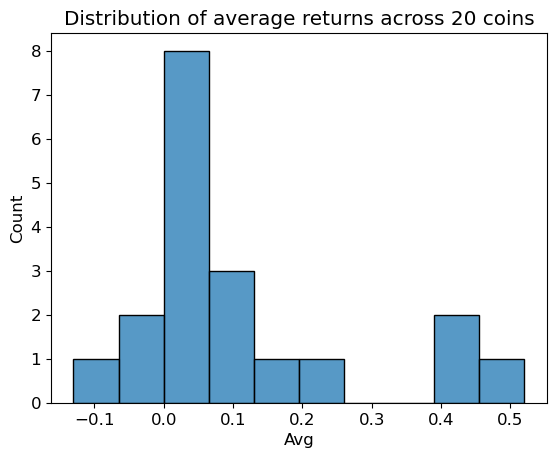

In [238]:
sns.histplot(df_all['Avg'], bins = 10)
plt.title('Distribution of average returns across 20 coins')

<AxesSubplot:xlabel='TR', ylabel='Count'>

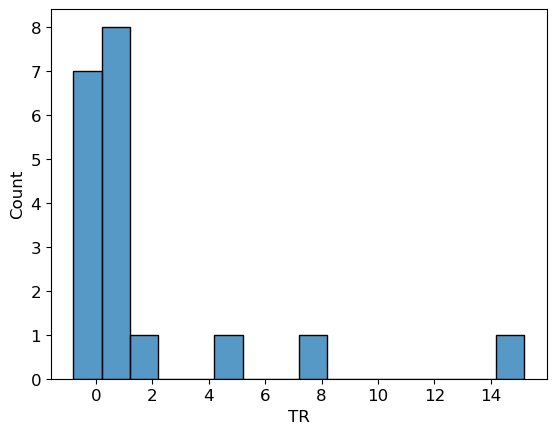

In [225]:
sns.histplot(df_all['TR'])

<AxesSubplot:xlabel='hit_rate', ylabel='Count'>

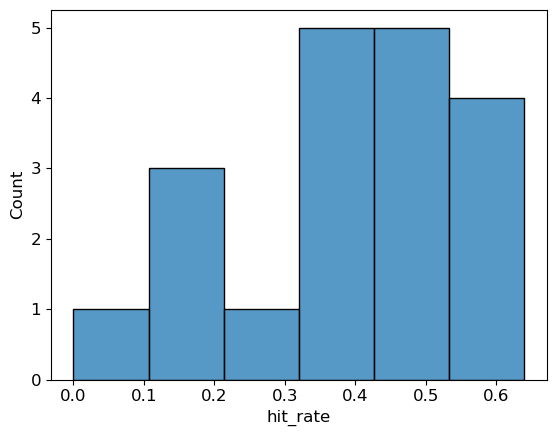

In [226]:
sns.histplot(df_all['hit_rate'])

#### Overall then, we can say that the strategy consistently makes money in almost all cases, albeit during this time the crypto market also saw significant upside.

However, the actual hit rate of the strategy is fairly weak. The inclusion of the 10% allows the return distribution to be right skewed, keeping exposure to the large trending moves that are a feature in crypto while limiting downside on the losing trades. We could be more refined in our take profit discipline- here I have used 28 days for simplicity but we could use eg a 10 day ema break as a more sophisticated trailing stop.

#### So in conclusion, in answer to our original problem statement, it appears there may be some, albeit weak correlation between Telegram sentiment and Shill score and forward returns based on regression and Shap analysis. As part of a clustering strategy, the returns do seem to be fairly compelling, though there doesn't seem to be much positive correlation between the mean returns of the clusters and the shill score, sentiment or number of mentions. 

It seems that the returns seem to correlate well with more traditional momentum metrics like RSI, 10/20 EMA and also 10/20 acc (ie early change in momentum). While it is not shown above, looking at other coins, the clustering approach did generally identify early momentum clusters - ie being early to trades that performed very well and led to outsized returns.
